In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
tf.config.run_functions_eagerly(True)
print("Applied")

2024-04-12 13:17:14.572138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 13:17:15.105914: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fipulab/cuda/include:/home/fipulab/cuda/lib64:/home/fipulab/cuda:/usr/lib:/usr/include
2024-04-12 13:17:15.105956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fipulab/cuda/include:/home/fi

Applied


In [2]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    num_metrics = 3

    plt.figure(figsize=(12, num_metrics * 4))

    plt.subplot(num_metrics, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy ({model_name})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(num_metrics, 1, 2)
    plt.plot(history.history['sparse_top_k_categorical_accuracy'])
    plt.plot(history.history['val_sparse_top_k_categorical_accuracy'])
    plt.title(f'SparseTopKCategoricalAccuracy ({model_name})')
    plt.ylabel('Top-2 genres Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(num_metrics, 1, 3)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss ({model_name})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_history(history, 'model0')

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    train_loss, train_accuracy, top2 = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_accuracy, top2 = model.evaluate(X_test, y_test, verbose=0)
    print(f"GTZAN Training Accuracy ({model_name}): {train_accuracy*100:.2f}%")
    print(f"GTZAN Test Accuracy ({model_name}): {test_accuracy*100:.2f}%")
    print(f"GTZAN Test top2 ({model_name}): {top2*100:.2f}%")

# Example usage:
# evaluate_model(model, X_train, y_train, X_test, y_test, 'model0')

In [19]:
"""
!pip install tensorflow==2.11.0
!pip install Pillow==9.5.0
!pip install librosa
!pip install image
!pip install visualkeras
!pip install matplotlib
!pip install pydot
!pip install graphviz
!pip install pysndfx
!pip install sox
"""

'\n!pip install tensorflow==2.11.0\n!pip install Pillow==9.5.0\n!pip install librosa\n!pip install image\n!pip install visualkeras\n!pip install matplotlib\n!pip install pydot\n!pip install graphviz\n!pip install pysndfx\n!pip install sox\n'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sox: filename=sox-1.5.0-py3-none-any.whl size=40039 sha256=4399dda67d1609bc49073cf682d69563531e774d30d7a1a8772904c2c4db53ac
  Stored in directory: /home/fipulab/.cache/pip/wheels/82/04/96/625c0e92308762f097033f3b12c43cdd16f30e88cd8ed592c7
Successfully built sox


# Unzip dataset
Run only once

In [ ]:
"""
import zipfile

zip_file_path = 'dataset/GTZAN/gtzan.zip'

output_directory = 'dataset/GTZAN'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_directory)

print(f"Extracted files to {output_directory}")
"""

# Load audio data
## GTZAN Dataset
- 10 classes representing music genres (blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock)

[Available here](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

## Load raw audio data

In [6]:
import os
import librosa

def load_audio_data(dataset_path="dataset/GTZAN"):
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    audio_data = {}
    for genre in genres:
        genre_path = f'{dataset_path}/{genre}'
        try:
            audio_files = os.listdir(genre_path)
        except IsADirectoryError:
            continue  # Skip this iteration if the expected file path is actually a directory
        audio_data[genre] = {}
        for file in audio_files:
            try:
                file_path = f'{genre_path}/{file}'
                audio, _ = librosa.load(file_path, sr=None)
                audio_data[genre][file[:-4]] = audio
            except IsADirectoryError:
                continue  # Ignore directories inside the genre folder
    return audio_data

def test_sample_rate(dataset_path="dataset/GTZAN"):
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    sample_rates = {}
    for genre in genres:
        genre_path = f'{dataset_path}/{genre}'
        try:
            audio_files = os.listdir(genre_path)
        except IsADirectoryError:
            continue  # Skip this iteration if the expected file path is actually a directory
        if not audio_files:
            continue  # Skip if no audio files are found
        file_path = f'{genre_path}/{audio_files[0]}'
        try:
            _, sample_rate = librosa.load(file_path, sr=None)
        except IsADirectoryError:
            continue  # Ignore directories inside the genre folder
        sample_rates[genre] = sample_rate
        print(f'Sample rate of {audio_files[0]} in {genre} genre: {sample_rate / 1000} kHz')
    return sample_rates

dataset_path = 'dataset/GTZAN/genres_original'
audio_data = load_audio_data(dataset_path)
sample_rates = test_sample_rate(dataset_path)

Sample rate of blues.00060.wav in blues genre: 22.05 kHz
Sample rate of classical.00025.wav in classical genre: 22.05 kHz
Sample rate of country.00055.wav in country genre: 22.05 kHz
Sample rate of disco.00084.wav in disco genre: 22.05 kHz
Sample rate of hiphop.00008.wav in hiphop genre: 22.05 kHz
Sample rate of jazz.00022.wav in jazz genre: 22.05 kHz
Sample rate of metal.00047.wav in metal genre: 22.05 kHz
Sample rate of pop.00033.wav in pop genre: 22.05 kHz
Sample rate of reggae.00014.wav in reggae genre: 22.05 kHz
Sample rate of rock.00049.wav in rock genre: 22.05 kHz


## Simple audio waveform visualization

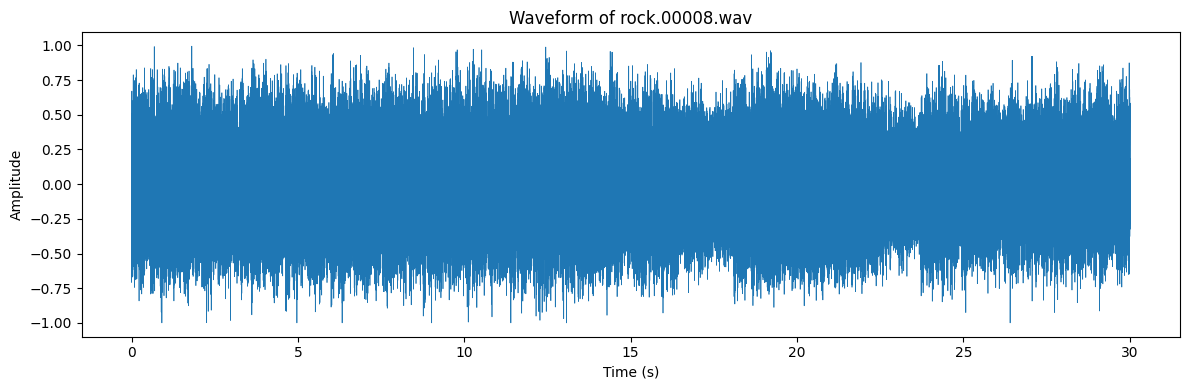

In [3]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

AUDIO_FILE = 'dataset/GTZAN/genres_original/rock/rock.00008.wav'
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)

# Generate time values for each sample
times = np.arange(len(samples)) / sample_rate

plt.figure(figsize=(12, 4))
plt.plot(times, samples, lw=0.5)
plt.title(f'Waveform of rock.00008.wav')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import Audio
Audio(AUDIO_FILE)

In [ ]:
print ('Example shape ', samples.shape, 'Sample rate ', sample_rate, 'Data type', type(samples))
print (samples[22400:22420])

# Spectrograms

### 1. Short-Time Fourier Transform (STFT) Spectrogram
- uses STFT to calculate spectrogram
- converted to DB scale using amplitude_to_db
- linear frequency axis, meaning each frequency bin corresponds linearly to its actual frequency in Hz (y_axis='hz')

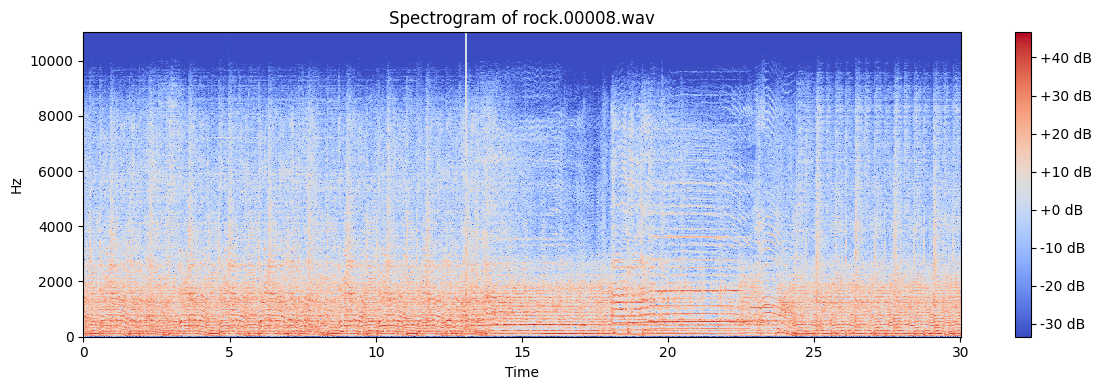

In [20]:
# Compute the Short-Time Fourier Transform (STFT)
stft = librosa.stft(samples)
# Convert the complex-valued STFT to a magnitude spectrum
magnitude = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12, 4))
librosa.display.specshow(magnitude, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of rock.00008.wav')
plt.tight_layout()
plt.show()


### 2. Mel Spectrogram
- the mel scale approximates the human auditory system's response to sound, meaning it emphasizes frequencies that are more significant to human hearing
- spectrogram power values are converted to DB using librosa.power_to_db

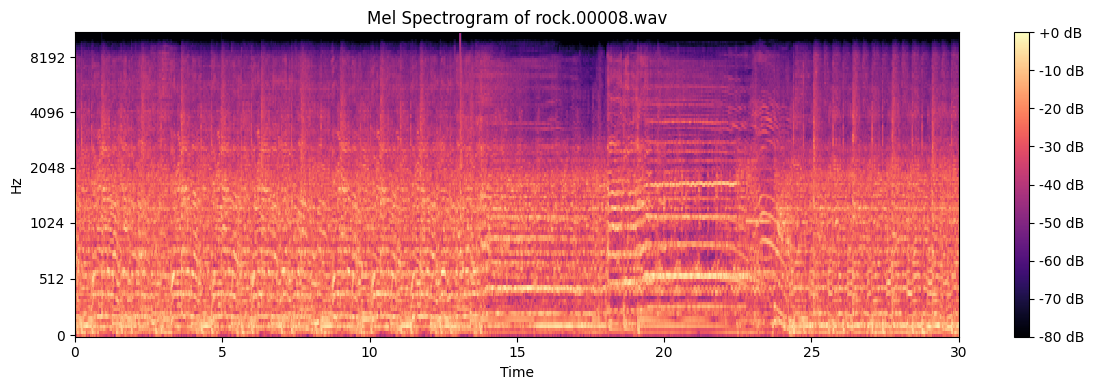

In [22]:
mel_spectrogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of rock.00008.wav')
plt.tight_layout()
plt.show()


In [26]:
print(type(mel_spectrogram_db), mel_spectrogram_db.shape)

<class 'numpy.ndarray'> (128, 1293)


### MEL and STFT Spectrograms

In [6]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

SPECTROGRAM_WIDTH = 5
SPECTROGRAM_HEIGHT = 2

def create_spectrogram(audio, sr, kind='mel', save_path=None):
    """
    Generate and save a spectrogram of the specified kind.

    Parameters:
    audio (ndarray): Audio time series.
    sr (int): Sampling rate of the audio.
    kind (str): Type of spectrogram to generate ('mel' or 'linear').
    save_path (str): Path to save the spectrogram image. If None, the image is not saved.
    """
    plt.figure(figsize=(SPECTROGRAM_WIDTH, SPECTROGRAM_HEIGHT))

    if kind == 'mel':
        # Compute Mel spectrogram
        S = librosa.feature.melspectrogram(y=audio, sr=sr)
        S_DB = librosa.power_to_db(S, ref=np.max)

        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram')

    elif kind == 'stft':
        # Compute linear-frequency spectrogram using STFT
        S = np.abs(librosa.stft(audio))
        S_DB = librosa.amplitude_to_db(S, ref=np.max)

        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Linear-frequency Spectrogram')

    else:
        raise ValueError("kind must be 'mel' or 'linear'")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [7]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

SPECTROGRAM_WIDTH = 5
SPECTROGRAM_HEIGHT = 2

# without labels - image only
def save_spectrogram(audio, sr, save_path, kind='mel', n_fft=2048, hop_length=512, n_mels=128):
    if os.path.exists(save_path):
        print(f'{save_path} already exists')
        return

    fig, ax = plt.subplots(figsize=(SPECTROGRAM_WIDTH, SPECTROGRAM_HEIGHT))
    ax.axis('off')

    if kind == 'mel':
        S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, x_axis=None, y_axis=None, sr=sr, fmax=8000, ax=ax)
    elif kind == 'stft':
        S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        librosa.display.specshow(S_dB, x_axis=None, y_axis=None, sr=sr, ax=ax)

    fig.tight_layout(pad=0)
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close(fig)
    print(f'{save_path} - created')

def process_clip(task):
    genre, clip, file_name, save_path = task
    save_spectrogram(clip, DEFAULT_SAMPLE_RATE, save_path, kind='mel', n_fft=4096, hop_length=256, n_mels=256)



## In summary, the main differences are:

1. The type of **frequency scale** used: linear (Hz) in the first snippet, Mel in the second.

2. The **type of transform** to generate the spectrogram: STFT for the linear-frequency spectrogram, and Mel-transform for the Mel-frequency spectrogram.

3. The **function used for conversion to decibels**: amplitude_to_db for the linear-frequency spectrogram, and power_to_db for the Mel-frequency spectrogram. They both convert amplitude and power measurements to logarithmic decibel (dB) scale. Amplitude func must convert amplitude values to power first, while Power func converts power straight to dB.

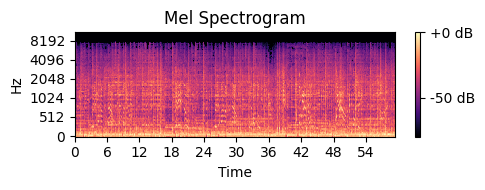

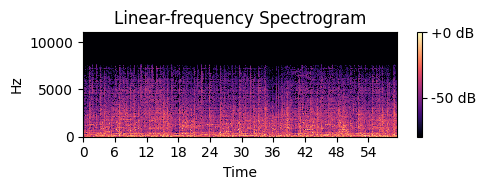

In [20]:

clip = audio_data["rock"]["Hey Joe"]
sr = 22050  # Default sampling rate for librosa

create_spectrogram(clip, sr, kind='mel')
create_spectrogram(clip, sr, kind='stft')

## Generating our own spectrograms from raw audio

- generating only mel spectrograms

In [8]:
import os
import gc
from concurrent.futures import ProcessPoolExecutor

DEFAULT_SAMPLE_RATE = 22050

# Generate and save spectrograms
for genre, files in audio_data.items():
    tasks = []
    genre_path = f'dataset/spotify_mp3/{genre}'
    os.makedirs(genre_path, exist_ok=True)
    for file_name, clip in files.items():
        save_path = f'{genre_path}/{file_name}.png'
        tasks.append((genre, clip, file_name, save_path))

    with ProcessPoolExecutor() as executor:
        executor.map(process_clip, tasks)

dataset/spotify_mp3/blues/Leaving Trunk.png - created
dataset/spotify_mp3/blues/Sadie.png - created
dataset/spotify_mp3/blues/Double Trouble.png - created
dataset/spotify_mp3/blues/Black Magic Woman - 2018 Master.png - created
dataset/spotify_mp3/blues/T-Bone Shuffle.png - created
dataset/spotify_mp3/blues/Part Time Love.png - createddataset/spotify_mp3/blues/Junker's Blues.png - created

dataset/spotify_mp3/blues/Call It Stormy Monday.png - created
dataset/spotify_mp3/blues/Albert's Shuffle.png - created
dataset/spotify_mp3/blues/Stumble.png - created
dataset/spotify_mp3/blues/Mean Old World.png - created
dataset/spotify_mp3/blues/Damn Right, I've Got the Blues.png - created
dataset/spotify_mp3/blues/The Sky Is Crying.png - created
dataset/spotify_mp3/blues/Feels Like Rain (feat. Bonnie Raitt).png - created
dataset/spotify_mp3/blues/Love Struck Baby.png - created
dataset/spotify_mp3/blues/All Your Love.png - created
dataset/spotify_mp3/blues/Blues for Mama.png - created
dataset/spotif

dataset/spotify_mp3/jazz/jazz is for ordinary people.png - created
dataset/spotify_mp3/jazz/Milestones (feat. John Coltrane, Cannonball Adderley, Red Garland, Paul Chambers & Philly Joe Jones).png - created
dataset/spotify_mp3/jazz/Mack the Knife.png - created
dataset/spotify_mp3/jazz/Body and Soul.png - created
dataset/spotify_mp3/jazz/Besame Mucho.png - created
dataset/spotify_mp3/jazz/'Round Midnight (feat. John Coltrane, Red Garland, Paul Chambers & Philly Joe Jones).png - created
dataset/spotify_mp3/jazz/Blue in Green (feat. John Coltrane & Bill Evans).png - created
dataset/spotify_mp3/metal/Inside the Fire.png - created
dataset/spotify_mp3/metal/Fear Of The Dark - 1998 Remastered Version.png - created
dataset/spotify_mp3/metal/The Last Fight.png - created
dataset/spotify_mp3/metal/Psychosocial.png - createddataset/spotify_mp3/metal/Wait and Bleed.png - created

dataset/spotify_mp3/metal/Skills in Pills.png - createddataset/spotify_mp3/metal/Spit It Out.png - created

dataset/spot

## Preview spectrogram function

In [71]:
import matplotlib.pyplot as plt
from PIL import Image

def preview_spectrogram(image_path, show_label=False, cmap=None):
    """
    Display a spectrogram image from the given path.

    :param image_path: Path to the spectrogram image file.
    :param show_label: If True, display the image with axes and labels; otherwise, display without.
    :param cmap: Colormap for displaying the image. Default is None (matplotlib's default colormap).
    """
    image = Image.open(image_path)
    plt.figure(figsize=(SPECTROGRAM_WIDTH, SPECTROGRAM_HEIGHT))
    plt.imshow(image, cmap=cmap)  # Use the specified colormap

    if not show_label:
        plt.axis('off')

    plt.show()

# Usage example:
# preview_spectrogram('dataset/mel_spectrograms_raw/blues/blues.0.png', show_label=False)

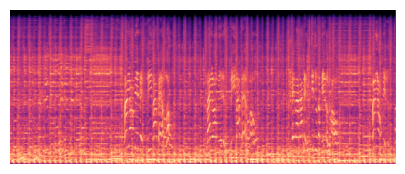

(0, 255, (200, 500, 4))

In [77]:
import numpy as np
from PIL import Image

spectrogram_image =  np.array(Image.open("dataset/mel_spectrograms_raw/blues/blues.00000.png"))

min_value = spectrogram_image.min()
max_value = spectrogram_image.max()
shape = spectrogram_image.shape

preview_spectrogram('dataset/mel_spectrograms_raw/blues/blues.00000.png', show_label=False)

min_value, max_value, shape # We can use Min-Max Scaling normalization and just divide by 255

In [2]:
import os
from PIL import Image

def convert_folder_to_grayscale(source_folder, target_folder):
    """
    Converts all images in source_folder to grayscale and saves them in target_folder.

    :param source_folder: Folder containing the source images.
    :param target_folder: Folder where the grayscale images will be saved.
    """
    os.makedirs(target_folder, exist_ok=True)

    for file_name in os.listdir(source_folder):
        source_path = os.path.join(source_folder, file_name)
        
        if os.path.isfile(source_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = Image.open(source_path)

            # Convert the image to grayscale
            grayscale_image = image.convert("L")

            target_path = os.path.join(target_folder, file_name)

            grayscale_image.save(target_path)
            print(f'Grayscale image saved to {target_path}')

In [4]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for genre in genres:
    source_folder = f'dataset/mel_spectrograms_augmentation/pitch_shift_n-1/{genre}/'
    target_folder = f'dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/{genre}/'
    convert_folder_to_grayscale(source_folder, target_folder)
    print(f'Converted {genre} spectrograms to grayscale.')

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.83.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.46.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.72.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.34.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.96.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.44.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.47.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.11.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.14.png
Grayscale image saved to dat

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.16.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.68.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.93.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.71.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.61.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.76.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.4.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.80.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/blues/blues.41.png
Converted blues spectrograms 

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/classical/classical.76.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/classical/classical.94.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/classical/classical.62.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/classical/classical.53.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/classical/classical.91.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/classical/classical.45.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/classical/classical.25.png
Converted classical spectrograms to grayscale.
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.38.png
Grayscale image saved to data

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.19.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.51.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.0.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.45.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.70.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.43.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.52.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.53.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/country/country.

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/disco/disco.39.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/disco/disco.63.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/disco/disco.54.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/disco/disco.16.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/disco/disco.92.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/disco/disco.95.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/disco/disco.58.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/disco/disco.8.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/disco/disco.48.png
Grayscale image saved to data

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/hiphop/hiphop.82.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/hiphop/hiphop.10.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/hiphop/hiphop.68.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/hiphop/hiphop.48.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/hiphop/hiphop.59.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/hiphop/hiphop.12.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/hiphop/hiphop.5.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/hiphop/hiphop.30.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/hiphop/hiphop.77.png
Grayscale i

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/jazz/jazz.17.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/jazz/jazz.26.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/jazz/jazz.59.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/jazz/jazz.30.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/jazz/jazz.10.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/jazz/jazz.1.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/jazz/jazz.85.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/jazz/jazz.68.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/jazz/jazz.2.png
Grayscale image saved to dataset/mel_spectrogram

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/metal/metal.56.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/metal/metal.76.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/metal/metal.66.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/metal/metal.54.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/metal/metal.33.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/metal/metal.99.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/metal/metal.90.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/metal/metal.81.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/metal/metal.21.png
Grayscale image saved to dat

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/pop/pop.36.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/pop/pop.27.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/pop/pop.48.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/pop/pop.65.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/pop/pop.96.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/pop/pop.20.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/pop/pop.11.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/pop/pop.76.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/pop/pop.50.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_g

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/reggae/reggae.44.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/reggae/reggae.15.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/reggae/reggae.4.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/reggae/reggae.2.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/reggae/reggae.9.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/reggae/reggae.68.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/reggae/reggae.6.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/reggae/reggae.70.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/reggae/reggae.54.png
Grayscale imag

Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/rock/rock.20.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/rock/rock.13.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/rock/rock.95.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/rock/rock.47.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/rock/rock.84.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/rock/rock.43.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/rock/rock.39.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/rock/rock.88.png
Grayscale image saved to dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1/rock/rock.72.png
Grayscale image saved to dataset/mel_spectrogr

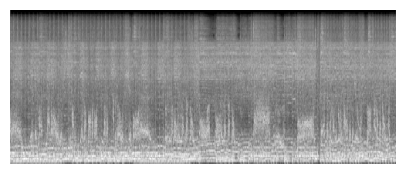

(0, 246, (200, 500))

In [52]:
import numpy as np
from PIL import Image

spectrogram_image =  np.array(Image.open("dataset/mel_spectrograms_grayscale/metal/metal.2.png"))

min_value = spectrogram_image.min()
max_value = spectrogram_image.max()
shape = spectrogram_image.shape

preview_spectrogram('dataset/mel_spectrograms_grayscale/metal/metal.2.png', show_label=False, cmap="gray")

min_value, max_value, shape # 200x500 px images, min 0 (black) - 246 max in this case, but stil dividing by 255 for norm...

## Function for finding duplicates

In [5]:
import os
import numpy as np
from PIL import Image

def find_duplicate_spectrograms(folder_path):
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
    spectrogram_arrays = []
    duplicate_files = []

    # Load each spectrogram and convert it to a numerical array
    for file_path in file_paths:
        img = Image.open(file_path)
        img_array = np.array(img)
        spectrogram_arrays.append((file_path, img_array))

    # Check for duplicates
    num_spectrograms = len(spectrogram_arrays)
    for i in range(num_spectrograms):
        for j in range(i + 1, num_spectrograms):
            if np.array_equal(spectrogram_arrays[i][1], spectrogram_arrays[j][1]):
                duplicate_files.append((spectrogram_arrays[i][0], spectrogram_arrays[j][0]))

    return duplicate_files

def find_duplicates_for_genres(genres):
    base_folder_path = 'dataset/mel_spectrograms_augmentation_grayscale/audio_pitch_shift_n2_grayscale'
    duplicates_by_genre = {}
    for genre in genres:
        folder_path = os.path.join(base_folder_path, genre)
        duplicates = find_duplicate_spectrograms(folder_path)
        duplicates_by_genre[genre] = duplicates
    return duplicates_by_genre

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

duplicates_by_genre = find_duplicates_for_genres(genres)

for genre, duplicates in duplicates_by_genre.items():
    if duplicates:
        print(f"\nFound duplicate spectrograms in {genre}:")
        for dup in duplicates:
            print(f"- {dup[0]} and {dup[1]} are duplicates")
    else:
        print(f"No duplicate spectrograms found in {genre}.")

def find_cross_genre_duplicates(base_folder_path):
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    spectrogram_arrays = []
    file_to_genre = {}
    duplicates_across_genres = []

    # Load all spectrograms and convert them to numerical arrays
    for genre in genres:
        folder_path = os.path.join(base_folder_path, genre)
        file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        for file_path in file_paths:
            img = Image.open(file_path)
            img_array = np.array(img)
            spectrogram_arrays.append((file_path, img_array))
            file_to_genre[file_path] = genre


    # Check for duplicates across genres
    num_spectrograms = len(spectrogram_arrays)
    for i in range(num_spectrograms):
        for j in range(i + 1, num_spectrograms):
            if np.array_equal(spectrogram_arrays[i][1], spectrogram_arrays[j][1]):
                if file_to_genre[spectrogram_arrays[i][0]] != file_to_genre[spectrogram_arrays[j][0]]:
                    duplicates_across_genres.append((spectrogram_arrays[i][0], spectrogram_arrays[j][0]))

    return duplicates_across_genres

No duplicate spectrograms found in blues.
No duplicate spectrograms found in classical.
No duplicate spectrograms found in country.
No duplicate spectrograms found in disco.
No duplicate spectrograms found in hiphop.
No duplicate spectrograms found in jazz.
No duplicate spectrograms found in metal.
No duplicate spectrograms found in pop.
No duplicate spectrograms found in reggae.
No duplicate spectrograms found in rock.


In [6]:
import os

def remove_duplicate_spectrograms(duplicates_by_genre):
    removed_files = []
    for genre, duplicates in duplicates_by_genre.items():
        for dup in duplicates:
            # Choose the second file in the tuple to remove
            file_to_remove = dup[1]
            try:
                os.remove(file_to_remove)
                print(f"Removing ${file_to_remove}")
                removed_files.append(file_to_remove)
            except OSError as e:
                print(f"Error deleting file {file_to_remove}: {e}")
    return removed_files
remove_duplicate_spectrograms(duplicates_by_genre)

[]

In [7]:
duplicates_across_genres = find_cross_genre_duplicates("dataset/mel_spectrograms_augmentation_grayscale/audio_pitch_shift_n2_grayscale")
print(duplicates_across_genres)

[]


In [8]:
def remove_cross_genre_duplicate_spectrograms(duplicates_across_genres):
    removed_files = []
    for file1, file2 in duplicates_across_genres:
        file_to_remove = file2

        if file_to_remove not in removed_files:
            try:
                os.remove(file_to_remove)
                print(f"Removing {file_to_remove}")
                removed_files.append(file_to_remove)
            except OSError as e:
                print(f"Error deleting file {file_to_remove}: {e}")

    return removed_files
remove_cross_genre_duplicate_spectrograms(duplicates_across_genres)

[]

# Dataset loader #1

In [10]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

X = []
y = []

GRAYSCALE = True;

for genre in genres:
    if GRAYSCALE:
        genre_folder = f'dataset/mel_spectrograms_raw_mp3/{genre}'
    else:
        genre_folder = f'dataset/mel_spectrograms_raw_mp3_grayscale/{genre}'
    for filename in os.listdir(genre_folder):
        image_path = os.path.join(genre_folder, filename)
        if (GRAYSCALE):
            image = load_img(image_path, target_size=(256, 256), color_mode = 'grayscale')
        else:
            image = load_img(image_path, target_size=(256, 256))
        X.append(img_to_array(image))
        y.append(genres.index(genre))

X = np.array(X) / 255.0  # Normalizing data using Min-Max Scaling as our spectrogram
y = np.array(y)


# Splitting data (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 700x 256x256 images and 3 color channels (RGB) 
print("X_train.shape", X_train.shape)
# 300x 256x256 images and 3 color channels (RGB) 
print("X_test.shape", X_test.shape)

# genres integers
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (690, 256, 256, 1)
X_test.shape (296, 256, 256, 1)
y_train.shape (690,)
y_test.shape (296,)


# Model #0


In [4]:
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.utils import plot_model


def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))

    model.add(Dense(10, activation='softmax'))  # 10 genres

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(X_train[0].shape)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)                1

2024-04-11 15:13:36.303275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 15:13:36.309443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 15:13:36.310122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 15:13:36.311237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [15]:
model = create_model(input_shape=X_train[0].shape)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])
# Sanity check
initial_loss, initial_accuracy, initial_top2 = model.evaluate(X_test, y_test, verbose=0)

print(f"Initial loss: {initial_loss:.2f}")
print(f"Initial accuracy: {initial_accuracy:.2f}")
print(f"Initial top2: {initial_top2:.2f}")

Initial loss: 2.31
Initial accuracy: 0.13
Initial top2: 0.20


# MODEL0.h5

In [54]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_callback = LearningRateScheduler(scheduler)

In [39]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 10

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model0.h5')

X_train shape: (690, 256, 256, 3)
y_train shape: (690,)
X_test shape: (296, 256, 256, 3)
y_test shape: (296,)
Model input shape: (None, 256, 256, 3)
Epoch 1/10
22/22 [==============================] - 2s 76ms/step - loss: 3.1836 - accuracy: 0.1725 - sparse_top_k_categorical_accuracy: 0.2623 - val_loss: 2.1922 - val_accuracy: 0.1993 - val_sparse_top_k_categorical_accuracy: 0.3243
Epoch 2/10
22/22 [==============================] - 2s 75ms/step - loss: 2.0618 - accuracy: 0.2406 - sparse_top_k_categorical_accuracy: 0.3435 - val_loss: 2.0969 - val_accuracy: 0.2838 - val_sparse_top_k_categorical_accuracy: 0.3750
Epoch 3/10
22/22 [==============================] - 2s 72ms/step - loss: 1.8612 - accuracy: 0.3696 - sparse_top_k_categorical_accuracy: 0.4826 - val_loss: 2.0640 - val_accuracy: 0.3547 - val_sparse_top_k_categorical_accuracy: 0.4291
Epoch 4/10
22/22 [==============================] - 2s 76ms/step - loss: 1.5831 - accuracy: 0.4826 - sparse_top_k_categorical_accuracy: 0.6101 - val_los

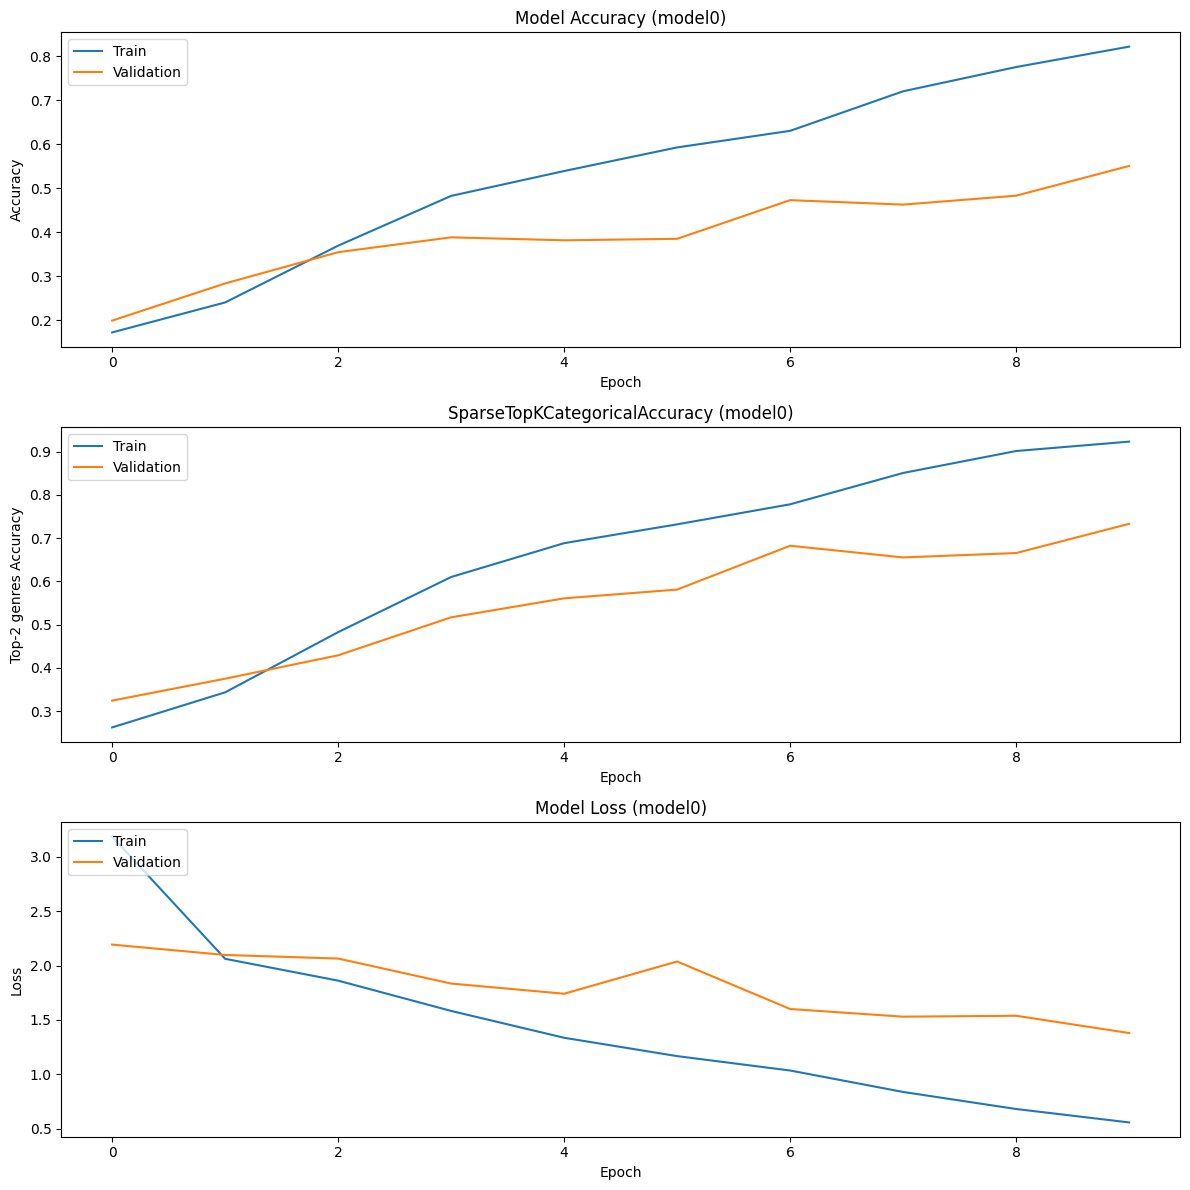

In [40]:
plot_history(history, 'model0')

In [45]:
evaluate_model(model, X_train, y_train, X_test, y_test, 'model0')

GTZAN Training Accuracy (model0): 88.26%
GTZAN Test Accuracy (model0): 55.07%
GTZAN Test top2 (model0): 73.31%


# MODEL1.h5

In [4]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model1.h5')

X_train shape: (690, 256, 256, 1)
y_train shape: (690,)
X_test shape: (296, 256, 256, 1)
y_test shape: (296,)
Model input shape: (None, 256, 256, 1)
Epoch 1/12


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-11 14:03:52.531345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 14:03:53.950156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


22/22 [==============================] - 4s 78ms/step - loss: 2.6467 - accuracy: 0.2145 - sparse_top_k_categorical_accuracy: 0.3681 - val_loss: 1.9803 - val_accuracy: 0.3209 - val_sparse_top_k_categorical_accuracy: 0.4696
Epoch 2/12
22/22 [==============================] - 1s 63ms/step - loss: 1.8099 - accuracy: 0.3638 - sparse_top_k_categorical_accuracy: 0.5333 - val_loss: 1.7747 - val_accuracy: 0.4088 - val_sparse_top_k_categorical_accuracy: 0.5777
Epoch 3/12
22/22 [==============================] - 1s 64ms/step - loss: 1.3169 - accuracy: 0.5478 - sparse_top_k_categorical_accuracy: 0.7362 - val_loss: 1.5989 - val_accuracy: 0.3919 - val_sparse_top_k_categorical_accuracy: 0.6149
Epoch 4/12
22/22 [==============================] - 1s 66ms/step - loss: 1.0422 - accuracy: 0.6391 - sparse_top_k_categorical_accuracy: 0.7971 - val_loss: 1.5334 - val_accuracy: 0.4189 - val_sparse_top_k_categorical_accuracy: 0.6351
Epoch 5/12
22/22 [==============================] - 1s 65ms/step - loss: 0.7525

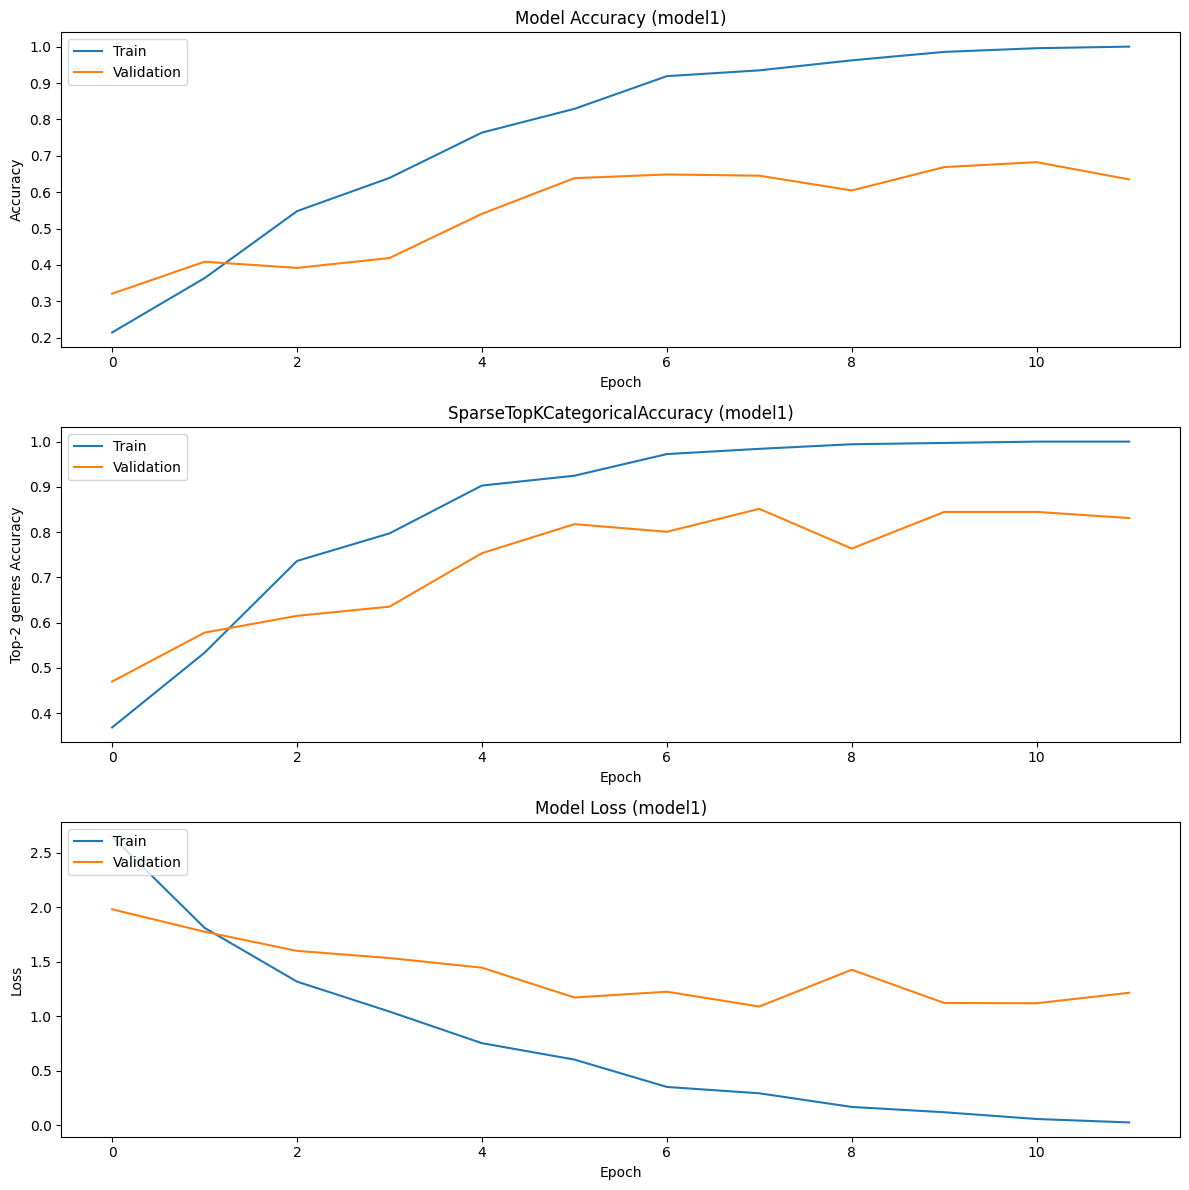

In [7]:
plot_history(history, 'model1')

In [8]:
evaluate_model(model, X_train, y_train, X_test, y_test, 'model1')

/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


GTZAN Training Accuracy (model1): 100.00%
GTZAN Test Accuracy (model1): 63.51%
GTZAN Test top2 (model1): 83.11%


# MODEL2.h5

In [5]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model2.h5')

X_train shape: (690, 256, 256, 3)
y_train shape: (690,)
X_test shape: (296, 256, 256, 3)
y_test shape: (296,)
Model input shape: (None, 256, 256, 3)
Epoch 1/12


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-11 14:25:30.821581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 14:25:32.150645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


22/22 [==============================] - 5s 95ms/step - loss: 3.0265 - accuracy: 0.1725 - sparse_top_k_categorical_accuracy: 0.2899 - val_loss: 2.1490 - val_accuracy: 0.1655 - val_sparse_top_k_categorical_accuracy: 0.4122
Epoch 2/12
22/22 [==============================] - 2s 72ms/step - loss: 1.9254 - accuracy: 0.3130 - sparse_top_k_categorical_accuracy: 0.4710 - val_loss: 2.0315 - val_accuracy: 0.2264 - val_sparse_top_k_categorical_accuracy: 0.4291
Epoch 3/12
22/22 [==============================] - 2s 70ms/step - loss: 1.6379 - accuracy: 0.3841 - sparse_top_k_categorical_accuracy: 0.5986 - val_loss: 1.8137 - val_accuracy: 0.3041 - val_sparse_top_k_categorical_accuracy: 0.5101
Epoch 4/12
22/22 [==============================] - 2s 71ms/step - loss: 1.1924 - accuracy: 0.5667 - sparse_top_k_categorical_accuracy: 0.7565 - val_loss: 1.4340 - val_accuracy: 0.4899 - val_sparse_top_k_categorical_accuracy: 0.6689
Epoch 5/12
22/22 [==============================] - 2s 74ms/step - loss: 0.9388

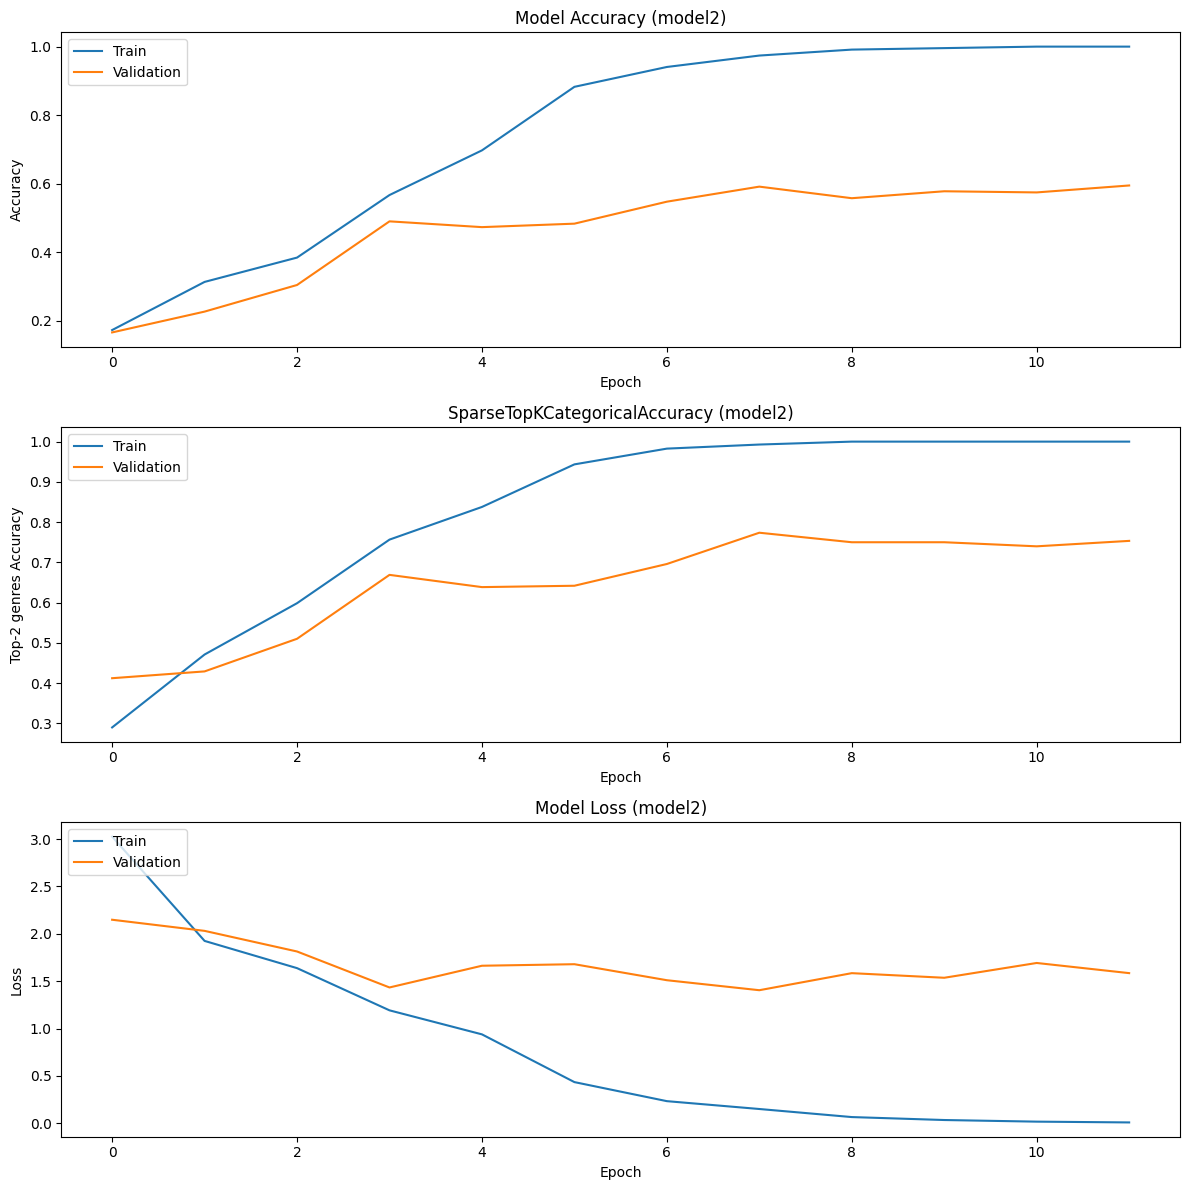

In [8]:
plot_history(history, 'model2')

In [9]:
evaluate_model(model, X_train, y_train, X_test, y_test, 'model2')

/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


GTZAN Training Accuracy (model2): 100.00%
GTZAN Test Accuracy (model2): 59.46%
GTZAN Test top2 (model2): 75.34%


# MODEL3.h5

In [12]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model3.h5')

X_train shape: (690, 256, 256, 1)
y_train shape: (690,)
X_test shape: (296, 256, 256, 1)
y_test shape: (296,)
Model input shape: (None, 256, 256, 1)
Epoch 1/12
22/22 [==============================] - 2s 73ms/step - loss: 3.1855 - accuracy: 0.1391 - sparse_top_k_categorical_accuracy: 0.2681 - val_loss: 2.1511 - val_accuracy: 0.1757 - val_sparse_top_k_categorical_accuracy: 0.3953
Epoch 2/12
22/22 [==============================] - 1s 62ms/step - loss: 1.9893 - accuracy: 0.2551 - sparse_top_k_categorical_accuracy: 0.4348 - val_loss: 1.9552 - val_accuracy: 0.2601 - val_sparse_top_k_categorical_accuracy: 0.4189
Epoch 3/12
22/22 [==============================] - 1s 63ms/step - loss: 1.7237 - accuracy: 0.3739 - sparse_top_k_categorical_accuracy: 0.5275 - val_loss: 1.8999 - val_accuracy: 0.2872 - val_sparse_top_k_categorical_accuracy: 0.4831
Epoch 4/12
22/22 [==============================] - 1s 64ms/step - loss: 1.3043 - accuracy: 0.5362 - sparse_top_k_categorical_accuracy: 0.7362 - val_los

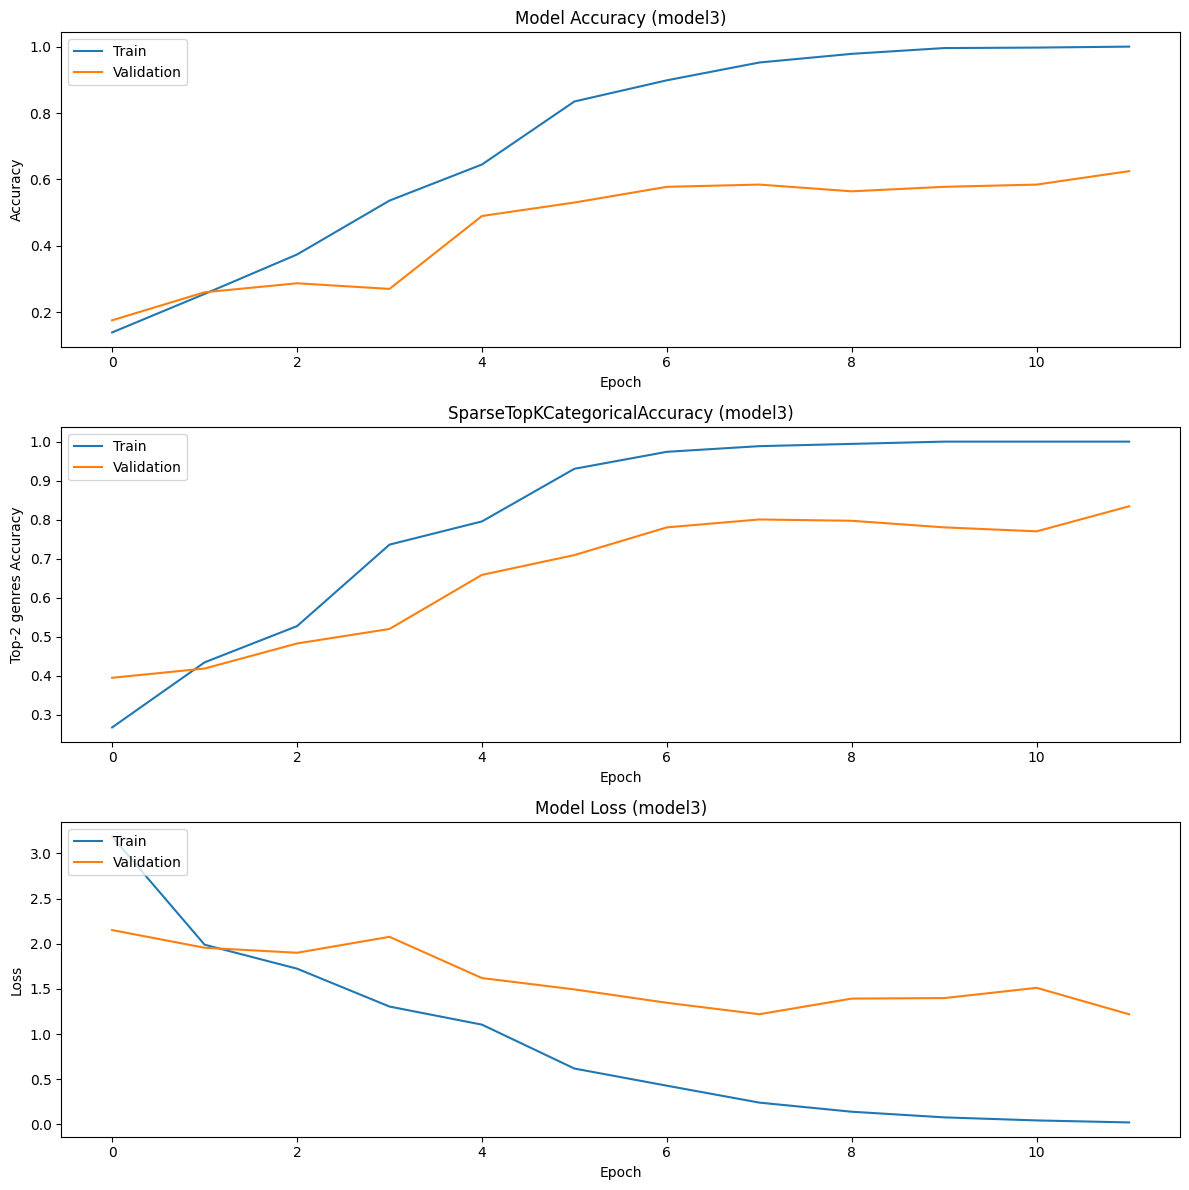

In [13]:
plot_history(history, 'model3')

In [14]:
evaluate_model(model, X_train, y_train, X_test, y_test, 'model3')

GTZAN Training Accuracy (model3): 100.00%
GTZAN Test Accuracy (model3): 62.50%
GTZAN Test top2 (model3): 83.45%


# Data Augmentation - Raw audio
### Involves manipulating the audio files to create varied but realistic versions of the original data.
### This helps in training more robust and generalized deep learning models in music genre classification
- **Time Shifting** - shifts the audio waveform to the left or the right by a random amount (won't be using cause it's not good to do it on music, only good for random sounds like dogs barking, cars, environmental sounds...) ❌
- **Pitch Shifting** - randomly modify the frequency of parts of the sound without altering its duration (move the melody up or down a couple of semi tones, not affecting the speed) ✅
- **Time Stretching** - Alters the speed of the audio clip without changing its pitch (useful for music) ✅
- **Reverberation/Echo** - Adding reverberation or echo effects can simulate different acoustic environments, such as small rooms, concert halls or large open arenas. 🥲TODO

## Audio Augmentation Functions
- time streching
- pitch scaling

In [4]:
import os
import librosa
from pysndfx import AudioEffectsChain
import numpy as np
import soundfile as sf
from concurrent.futures import ThreadPoolExecutor

def process_file(file, genre_dir, technique_save_dir, technique, sr, n_steps, stretch_factor):
    file_path = os.path.join(genre_dir, file)
    y, sr = librosa.load(file_path, sr=sr)

    if technique == 'pitch_shift':
        y_augmented = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    elif technique == 'time_stretch':
        y_augmented = librosa.effects.time_stretch(y, rate=stretch_factor)
    elif technique == 'reverb':
        fx = AudioEffectsChain().reverb()
        y_augmented = fx(y)
    elif technique == 'echo':
        fx = AudioEffectsChain().echo()
        y_augmented = fx(y)
    else:
        raise ValueError(f"Invalid technique: {technique}")

    save_path = os.path.join(technique_save_dir, f"{technique}_{file}")
    sf.write(save_path, y_augmented, sr)

def augment_and_save_audio(base_dir, save_dir, technique, stretch_factor=1.0, n_steps=0, max_workers=10):
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

    for genre in genres:
        technique_save_dir = os.path.join(save_dir, genre)
        os.makedirs(technique_save_dir, exist_ok=True)

        genre_dir = os.path.join(base_dir, genre)
        audio_files = os.listdir(genre_dir)

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            for file in audio_files:
                executor.submit(process_file, file, genre_dir, technique_save_dir, technique, None, n_steps, stretch_factor)

base_dir = "./dataset/GTZAN/genres_original"
save_dir = "./dataset/audio_effects/time_stretch_sf1.25"
augment_and_save_audio(base_dir, save_dir, 'time_stretch', stretch_factor=1.25)

## Generate Spectrograms from augmented raw audio data ()
### for now - pitch shift (n=2) and time stretch (sf = 0.85)

In [8]:
import os
import librosa
import gc
from concurrent.futures import ThreadPoolExecutor

DEFAULT_SAMPLE_RATE = 22050

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
augmentations = ['time_stretch_sf1.25', 'pitch_shift_n-1']

def load_and_process(task):
    genre, augmentation, file, idx = task
    file_path = f'./dataset/audio_effects/{augmentation}/{genre}/{file}'
    mel_save_path = f'./dataset/mel_spectrograms_augmentation/{augmentation}/{genre}/{genre}.{idx}.png'    
    if not os.path.exists(mel_save_path):
        clip, sr = librosa.load(file_path, sr=DEFAULT_SAMPLE_RATE)
        process_clip((genre, clip, file, mel_save_path))

    gc.collect()

tasks = []
for genre in genres:
    for augmentation in augmentations:
        audio_files = os.listdir(f'./dataset/audio_effects/{augmentation}/{genre}')
        os.makedirs(f'./dataset/mel_spectrograms_augmentation/{augmentation}/{genre}', exist_ok=True)

        for idx, file in enumerate(audio_files):
            print(f'Adding task for {genre}/{augmentation}: {file}') 
            tasks.append((genre, augmentation, file, idx))

print(f'Total tasks to process: {len(tasks)}')
with ThreadPoolExecutor(max_workers=10) as executor:
    executor.map(load_and_process, tasks)

Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00099.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00098.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00032.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00022.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00019.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00069.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00042.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00051.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00013.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00093.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00056.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00011.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00008.wav
Adding task for blues/time_stretch_sf1.25: time_stretch_blues.00

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.1.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.3.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.6.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.9.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.2.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.8.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.5.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.4.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.0.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.7.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.10.png - created
./dataset/mel_spectrograms_augm

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.98.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.94.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.95.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.93.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.99.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/blues/blues.97.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.0.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.1.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.3.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.2.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.4.png - created
./dataset/mel_spectrograms_augmentation/pitch_

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.93.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.92.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.94.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.98.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.1.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.96.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.95.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.97.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/blues/blues.99.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.2.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.0.png - created
./dataset/mel_spectrograms_augme

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.80.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.78.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.79.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.81.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.82.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.83.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.85.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.84.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.86.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/classical/classical.91.png - created
./dataset/mel_spectrograms_aug

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.69.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.68.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.71.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.67.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.70.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.74.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.73.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.72.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.78.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/classical.76.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/classical/clas

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.58.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.57.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.60.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.59.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.56.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.61.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.62.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.63.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.66.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/country.64.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/country/co

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.48.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.47.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.49.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.53.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.50.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.51.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.52.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.56.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.54.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.55.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/country/country.57.png - created
./dataset/mel_spectro

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.40.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.44.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.42.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.41.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.48.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.43.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.45.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.47.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.46.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.50.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/disco/disco.49.png - created
./dataset/mel_spectro

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.33.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.34.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.36.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.37.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.38.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.39.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.40.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.41.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.42.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.44.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/disco.46.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/disco/dis

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.26.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.30.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.31.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.32.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.34.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.33.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.35.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.42.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.39.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.37.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/hiphop/hiphop.36.png - created

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.24.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.23.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.22.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.27.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.26.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.25.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.28.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.29.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.30.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.32.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/hiphop/hiphop.31.png - created
./dataset/mel_spectrograms_augmentation/pit

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.18.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.17.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.16.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.21.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.20.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.22.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.23.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.24.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.25.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.27.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/jazz/jazz.26.png - created
./dataset/mel_spectrograms_augmentation/tim

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.12.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.16.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.15.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.13.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.14.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.18.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.17.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.20.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.19.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.21.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.22.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/jazz/jazz.26.png - created
./da

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.13.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.11.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.12.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.15.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.14.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.16.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.17.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.18.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.19.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.21.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/metal/metal.23.png - created
./dataset/mel_spectro

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.5.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.4.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.6.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.7.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.8.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.9.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.10.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.11.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.14.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.12.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.13.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/metal/metal.16.

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.1.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.2.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.3.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.4.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.5.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.6.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.7.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.8.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.9.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.11.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.10.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.12.png

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.98.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/pop/pop.99.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.1.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.0.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.3.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.2.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.4.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.5.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.6.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.7.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.8.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.11.png - created
./dataset/mel_spectrograms_au

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/pop/pop.98.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.1.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.3.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.2.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.4.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.5.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.6.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.7.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.9.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.8.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.10.png - created
./dataset/mel_spec

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.94.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.90.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.95.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.93.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.96.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.97.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.98.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/reggae/reggae.99.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.0.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.1.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.2.png - created
./dataset/mel_

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.86.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.89.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.88.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.87.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.90.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.91.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.92.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.95.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.93.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.94.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/reggae/reggae.96.png - created
./dataset/mel_spectrograms_augmentation/pit

./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.81.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.85.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.83.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.84.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.82.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.86.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.87.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.88.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.89.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.90.png - created
./dataset/mel_spectrograms_augmentation/time_stretch_sf1.25/rock/rock.91.png - created
./dataset/mel_spectrograms_augmentation/tim

./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.78.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.80.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.82.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.81.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.83.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.84.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.85.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.86.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.88.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.87.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.89.png - created
./dataset/mel_spectrograms_augmentation/pitch_shift_n-1/rock/rock.90.png - created
./da

# Dataset loader #2
1. Load original grayscale images from mel_spectrograms_grayscale for both training and testing
2. Load augmented images from **mel_spectrograms_augmentation_grayscale/audio_pitch_shift_n2_grayscale** and **mel_spectrograms_augmentation_grayscale/time_stretch_sf0.85_grayscale** for training only.

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def check_images_overlap(filenames_train, filenames_test, X_train, X_test):
    overlap_images = []
    for i, x_test_image in enumerate(X_test):
        for j, x_train_image in enumerate(X_train):
            if (x_test_image == x_train_image).all():
                overlap_images.append((filenames_test[i], filenames_train[j]))

    if overlap_images:
        print(f"Overlap found in image data: {overlap_images}")
    else:
        print("No overlap in image data.")
    return overlap_images

genre_to_label = {genre: index for index, genre in enumerate(genres)}

def load_images(folder, grayscale):
    images = []
    labels = []
    filenames = []

    for genre in os.listdir(folder):
        genre_folder = os.path.join(folder, genre)
        for filename in os.listdir(genre_folder):
            image_path = os.path.join(genre_folder, filename)
            if os.path.isfile(image_path):
                if grayscale:
                    image = load_img(image_path, target_size=(256, 256), color_mode='grayscale')
                else:
                    image = load_img(image_path, target_size=(256, 256))
                image = img_to_array(image)
                images.append(image)
                labels.append(genre_to_label[genre])  # Convert genre to integer label
                filenames.append(filename)

    return np.array(images), np.array(labels), filenames

# Load original
X_orig, y_orig, filenames_orig = load_images('dataset/mel_spectrograms_grayscale', grayscale=True)

X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    X_orig, y_orig, filenames_orig, test_size=0.35, random_state=35, stratify=y_orig
)

# Check for overlaps in image data #1
print("Check before adding augmented data")
image_overlaps = check_images_overlap(filenames_train, filenames_test, X_train, X_test)

# Load augmented images and add them to the training set
augmented_folders = [
    'dataset/mel_spectrograms_augmentation_grayscale/audio_pitch_shift_n2_grayscale',
    'dataset/mel_spectrograms_augmentation_grayscale/time_stretch_sf0.85_grayscale'
]



for folder in augmented_folders:
    X_aug, y_aug, _ = load_images(folder, grayscale=True)
    X_train = np.concatenate((X_train, X_aug))
    y_train = np.concatenate((y_train, y_aug))

print("X_aug.shape", X_aug.shape)
print("y_aug.shape", y_aug.shape)

    
X_train = X_train / 255.0
X_test = X_test / 255.0

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

# Print filenames for test images
#print("Filenames for X_test:", filenames_test)
#print("Filenames for X_train:", filenames_train)

def check_filenames_overlap(filenames_train, filenames_test):
    filenames_intersection = set(filenames_train) & set(filenames_test)
    if filenames_intersection:
        print(f"Overlap found in filenames: {filenames_intersection}")
    else:
        print("No overlap in filenames.")
    return filenames_intersection

# Check for overlaps in filenames
filename_overlaps = check_filenames_overlap(filenames_train, filenames_test)

# Check for overlaps in image data #2
print("Check on concatenated data")
image_overlaps = check_images_overlap(filenames_train, filenames_test, X_train, X_test)

Check before adding augmented data
No overlap in image data.
X_aug.shape (986, 256, 256, 1)
y_aug.shape (986,)
X_train.shape (2612, 256, 256, 1)
X_test.shape (346, 256, 256, 1)
y_train.shape (2612,)
y_test.shape (346,)
No overlap in filenames.
Check on concatenated data
No overlap in image data.


# MODEL4.h5

In [5]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model4.h5')

X_train shape: (1626, 256, 256, 1)
y_train shape: (1626,)
X_test shape: (346, 256, 256, 1)
y_test shape: (346,)
Model input shape: (None, 256, 256, 1)
Epoch 1/12


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-11 15:03:55.369975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 15:03:56.814724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


51/51 [==============================] - 6s 65ms/step - loss: 2.4656 - accuracy: 0.1857 - sparse_top_k_categorical_accuracy: 0.3616 - val_loss: 1.8100 - val_accuracy: 0.3006 - val_sparse_top_k_categorical_accuracy: 0.4855
Epoch 2/12
51/51 [==============================] - 3s 57ms/step - loss: 1.5277 - accuracy: 0.4625 - sparse_top_k_categorical_accuracy: 0.6335 - val_loss: 1.2137 - val_accuracy: 0.5405 - val_sparse_top_k_categorical_accuracy: 0.7370
Epoch 3/12
51/51 [==============================] - 3s 59ms/step - loss: 1.0360 - accuracy: 0.6476 - sparse_top_k_categorical_accuracy: 0.8026 - val_loss: 0.7901 - val_accuracy: 0.7225 - val_sparse_top_k_categorical_accuracy: 0.8815
Epoch 4/12
51/51 [==============================] - 3s 59ms/step - loss: 0.5133 - accuracy: 0.8444 - sparse_top_k_categorical_accuracy: 0.9379 - val_loss: 0.4429 - val_accuracy: 0.8642 - val_sparse_top_k_categorical_accuracy: 0.9480
Epoch 5/12
51/51 [==============================] - 3s 58ms/step - loss: 0.2141

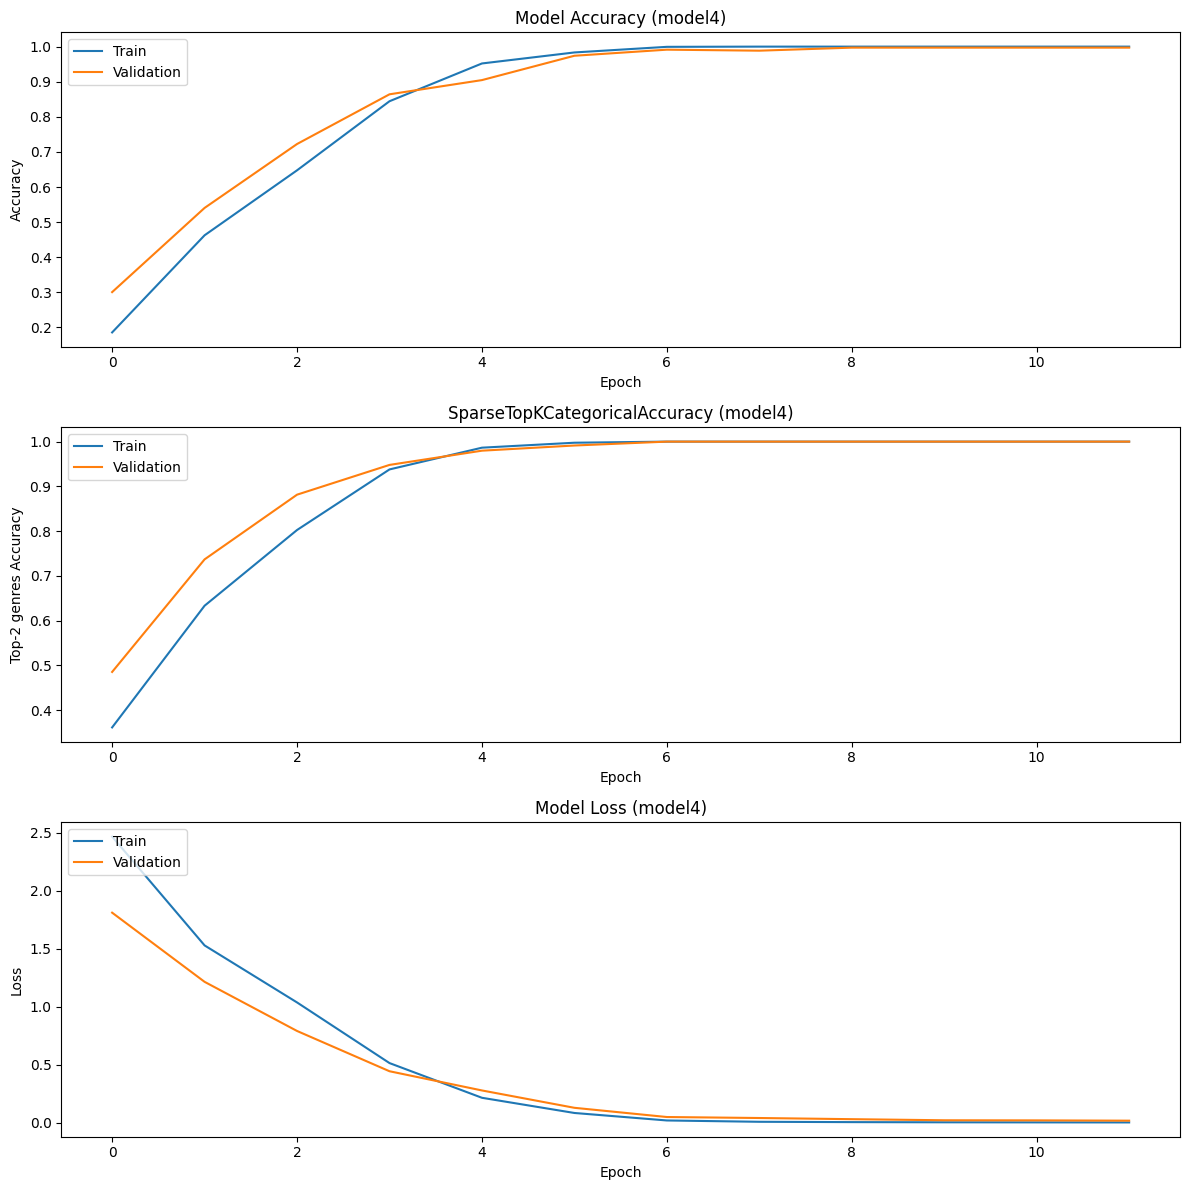

In [8]:
plot_history(history, 'model4')

In [10]:
evaluate_model(model, X_train, y_train, X_test, y_test, 'model4')

GTZAN Training Accuracy (model4): 100.00%
GTZAN Test Accuracy (model4): 99.71%
GTZAN Test top2 (model4): 100.00%


# MODEL5.h5

In [5]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model5.h5')

X_train shape: (2612, 256, 256, 1)
y_train shape: (2612,)
X_test shape: (346, 256, 256, 1)
y_test shape: (346,)
Model input shape: (None, 256, 256, 1)
Epoch 1/12


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-11 15:13:42.614834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 15:13:44.142144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


82/82 [==============================] - 8s 59ms/step - loss: 2.1754 - accuracy: 0.2301 - sparse_top_k_categorical_accuracy: 0.3790 - val_loss: 1.6683 - val_accuracy: 0.4509 - val_sparse_top_k_categorical_accuracy: 0.6503
Epoch 2/12
82/82 [==============================] - 4s 55ms/step - loss: 1.1630 - accuracy: 0.6106 - sparse_top_k_categorical_accuracy: 0.7902 - val_loss: 0.6804 - val_accuracy: 0.8035 - val_sparse_top_k_categorical_accuracy: 0.9220
Epoch 3/12
82/82 [==============================] - 5s 55ms/step - loss: 0.6096 - accuracy: 0.8113 - sparse_top_k_categorical_accuracy: 0.9273 - val_loss: 0.4284 - val_accuracy: 0.8699 - val_sparse_top_k_categorical_accuracy: 0.9566
Epoch 4/12
82/82 [==============================] - 5s 55ms/step - loss: 0.2475 - accuracy: 0.9349 - sparse_top_k_categorical_accuracy: 0.9828 - val_loss: 0.1821 - val_accuracy: 0.9566 - val_sparse_top_k_categorical_accuracy: 0.9855
Epoch 5/12
82/82 [==============================] - 5s 57ms/step - loss: 0.0777

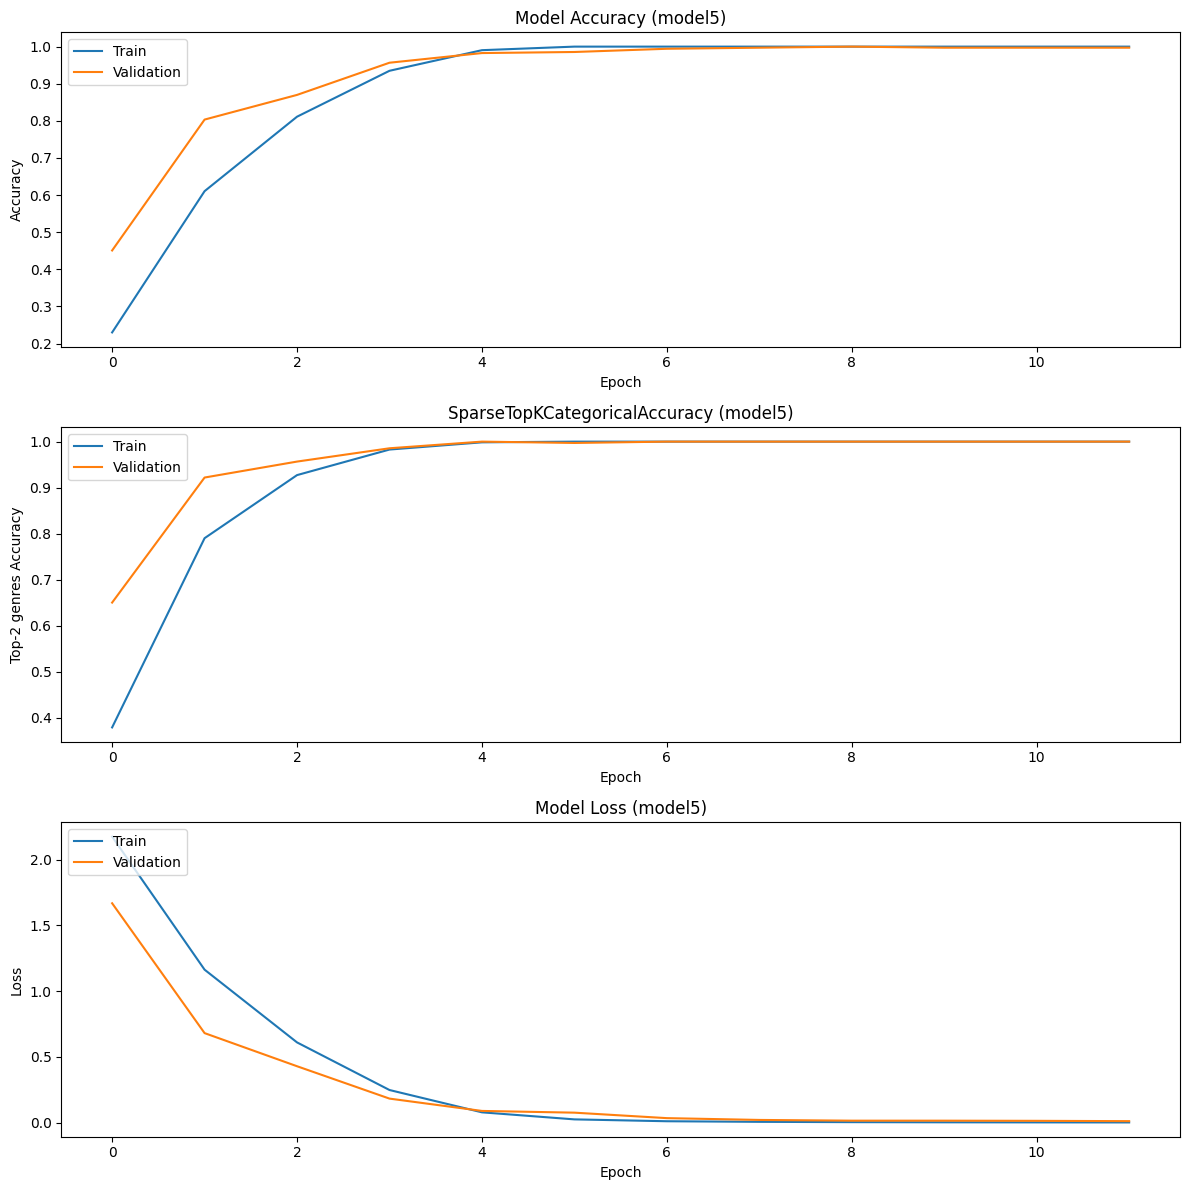

In [8]:
plot_history(history, 'model5')

In [9]:
evaluate_model(model, X_train, y_train, X_test, y_test, 'model5')

/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


GTZAN Training Accuracy (model5): 100.00%
GTZAN Test Accuracy (model5): 99.71%
GTZAN Test top2 (model5): 100.00%


# MODEL6,7,8.h5

In [5]:
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.utils import plot_model


def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(10, activation='softmax'))  # 10 genres

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(X_train[0].shape)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 64)       

In [6]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model8.h5')

X_train shape: (2612, 256, 256, 1)
y_train shape: (2612,)
X_test shape: (346, 256, 256, 1)
y_test shape: (346,)
Model input shape: (None, 256, 256, 1)
Epoch 1/12


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-11 15:36:09.860310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 15:36:11.285846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-11 15:36:11.555022: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the availabl

82/82 [==============================] - 8s 64ms/step - loss: 2.6397 - accuracy: 0.1677 - sparse_top_k_categorical_accuracy: 0.3025 - val_loss: 2.0991 - val_accuracy: 0.3006 - val_sparse_top_k_categorical_accuracy: 0.4075
Epoch 2/12
82/82 [==============================] - 5s 58ms/step - loss: 2.0718 - accuracy: 0.2764 - sparse_top_k_categorical_accuracy: 0.4261 - val_loss: 1.9243 - val_accuracy: 0.3671 - val_sparse_top_k_categorical_accuracy: 0.4971
Epoch 3/12
82/82 [==============================] - 5s 58ms/step - loss: 1.7834 - accuracy: 0.3863 - sparse_top_k_categorical_accuracy: 0.5456 - val_loss: 1.3395 - val_accuracy: 0.5636 - val_sparse_top_k_categorical_accuracy: 0.7023
Epoch 4/12
82/82 [==============================] - 5s 58ms/step - loss: 1.3630 - accuracy: 0.5249 - sparse_top_k_categorical_accuracy: 0.7041 - val_loss: 1.0031 - val_accuracy: 0.6676 - val_sparse_top_k_categorical_accuracy: 0.8699
Epoch 5/12
82/82 [==============================] - 5s 58ms/step - loss: 0.9862

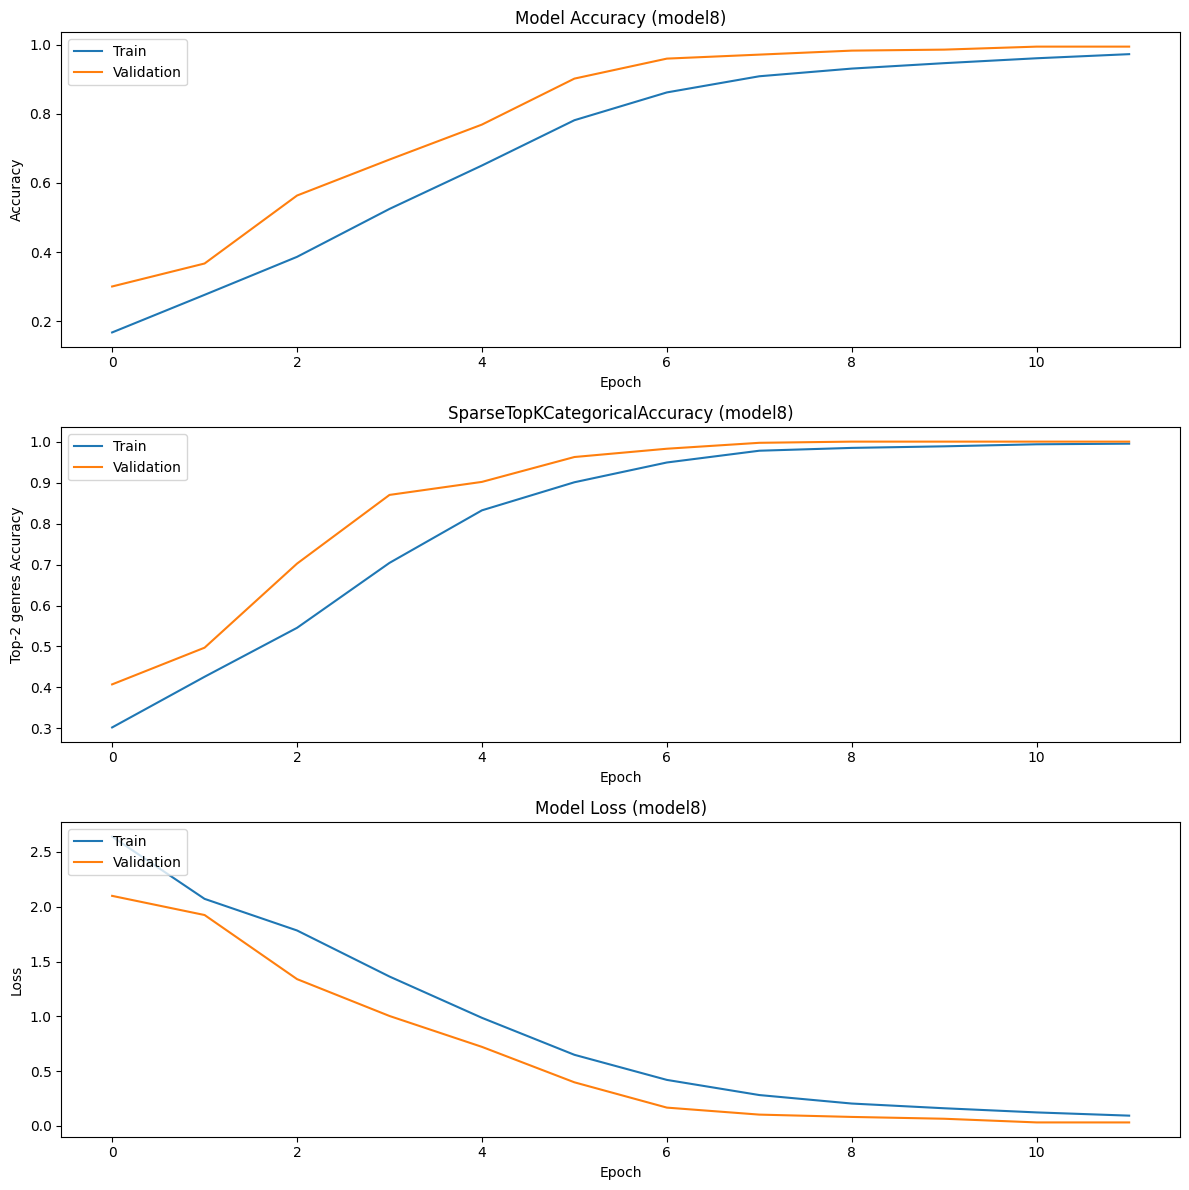

In [7]:
plot_history(history, 'model8')

In [8]:
evaluate_model(model, X_train, y_train, X_test, y_test, 'model8')

GTZAN Training Accuracy (model8): 100.00%
GTZAN Test Accuracy (model8): 99.42%
GTZAN Test top2 (model8): 100.00%


<hr>

# Data Augmentation - Spectrograms
We will apply 2 SpecAugment (Spectrogram augmentation) techniques:
- Time masking - This technique masks a consecutive segment of time steps, leading to a "vertical" line in the spectrogram
- Frequency Masking - randomly mask out a range of consecutive frequencies by adding horizontal bars on the spectrogram.

## Spectrogram Augmentation Functions

### Frequency masking
- Frequency Masking - randomly mask out a range of consecutive frequencies by adding horizontal bars on the spectrogram.

In [42]:
def frequency_masking(spectrogram, F=30, num_masks=1, replace_with_zero=True):
    masked_spec = np.copy(spectrogram)
    num_channels, num_frames = masked_spec.shape

    for i in range(num_masks):
        f = np.random.uniform(low=0.0, high=F)
        f = int(f)
        f0 = np.random.uniform(low=0.0, high=num_channels - f)
        f0 = int(f0)

        # Determine the value to replace the mask with
        if replace_with_zero:
            masked_value = 0
        else:
            masked_value = masked_spec.mean()

        for j in range(f0, f0 + f):
            if j < num_channels:
                masked_spec[j, :] = masked_value

    return masked_spec

def frequency_masking_rgb(image, F=30, num_masks=1, replace_with_zero=True):
    masked_image = np.copy(image)

    # Apply frequency masking to each channel
    for channel in range(image.shape[2]):
        masked_image[:,:,channel] = frequency_masking(masked_image[:,:,channel], F=F, num_masks=num_masks, replace_with_zero=replace_with_zero)

    return masked_image


### Time masking
- Time masking - This technique masks a consecutive segment of time steps, leading to a "vertical" line in the spectrogram

In [43]:
def time_masking_rgb(spectrogram, T=40, num_masks=1, replace_with_zero=True):

    masked_spec = np.copy(spectrogram)
    num_channels, num_frames, _ = masked_spec.shape

    for i in range(num_masks):
        t = np.random.uniform(low=0.0, high=T)
        t = int(t)
        t0 = np.random.uniform(low=0.0, high=num_frames - t)
        t0 = int(t0)

        if replace_with_zero:
            masked_value = 0
        else:
            masked_value = masked_spec.mean(axis=(0,1))

        for j in range(t0, t0 + t):
            if j < num_frames:
                masked_spec[:, j, :] = masked_value

    return masked_spec


In [44]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ProcessPoolExecutor

def process_image(task):
    file_path, output_dir_freq, output_dir_time, F, T, num_masks, replace_with_zero = task

    image = np.array(Image.open(file_path))
    file_name = os.path.basename(file_path)

    if image.size == 0:
        print(f'Error loading {file_name}')
        return

    # Apply frequency masking and save
    freq_masked_image = frequency_masking_rgb(image, F=F, num_masks=num_masks, replace_with_zero=replace_with_zero)
    Image.fromarray(freq_masked_image).save(os.path.join(output_dir_freq, file_name))

    # Apply time masking and save
    time_masked_image = time_masking_rgb(image, T=T, num_masks=num_masks, replace_with_zero=replace_with_zero)
    Image.fromarray(time_masked_image).save(os.path.join(output_dir_time, file_name))

    print(f'{file_name} processed and saved in {output_dir_freq} and {output_dir_time}')



def apply_masking_and_save(base_input_dir, base_output_dir_freq, base_output_dir_time, genres, F=30, T=40, num_masks=1, replace_with_zero=True):
    with ProcessPoolExecutor() as executor:
        tasks = []
        for genre in genres:
            input_dir = os.path.join(base_input_dir, genre)
            output_dir_freq = os.path.join(base_output_dir_freq, genre)
            output_dir_time = os.path.join(base_output_dir_time, genre)

            os.makedirs(output_dir_freq, exist_ok=True)
            os.makedirs(output_dir_time, exist_ok=True)

            for file_name in os.listdir(input_dir):
                file_path = os.path.join(input_dir, file_name)
                tasks.append((file_path, output_dir_freq, output_dir_time, F, T, num_masks, replace_with_zero))

        # Process tasks
        executor.map(process_image, tasks)


base_input_directory = 'dataset/mel_spectrograms_raw_mp3' 
base_output_directory_freq = 'dataset/mel_spectrograms_specaug_mp3/frequency_masked'
base_output_directory_time = 'dataset/mel_spectrograms_specaug_mp3/time_masked'

# List of genres
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

apply_masking_and_save(base_input_directory, base_output_directory_freq, base_output_directory_time, genres)


blues.00063.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/blues and dataset/mel_spectrograms_specaug_mp3/time_masked/blues
blues.00000.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/blues and dataset/mel_spectrograms_specaug_mp3/time_masked/bluesblues.00017.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/blues and dataset/mel_spectrograms_specaug_mp3/time_masked/bluesblues.00075.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/blues and dataset/mel_spectrograms_specaug_mp3/time_masked/blues
blues.00028.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/blues and dataset/mel_spectrograms_specaug_mp3/time_masked/blues


blues.00089.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/blues and dataset/mel_spectrograms_specaug_mp3/time_masked/bluesblues.00019.png processed and saved in dataset/mel_sp

classical.00050.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/classical and dataset/mel_spectrograms_specaug_mp3/time_masked/classicalblues.00009.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/blues and dataset/mel_spectrograms_specaug_mp3/time_masked/blues


classical.00044.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/classical and dataset/mel_spectrograms_specaug_mp3/time_masked/classical
classical.00046.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/classical and dataset/mel_spectrograms_specaug_mp3/time_masked/classicalclassical.00011.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/classical and dataset/mel_spectrograms_specaug_mp3/time_masked/classical



classical.00031.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/classical and dataset/mel_spectrograms_specaug_mp3/time_masked

classical.00057.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/classical and dataset/mel_spectrograms_specaug_mp3/time_masked/classicalclassical.00028.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/classical and dataset/mel_spectrograms_specaug_mp3/time_masked/classicalclassical.00014.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/classical and dataset/mel_spectrograms_specaug_mp3/time_masked/classical

classical.00099.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/classical and dataset/mel_spectrograms_specaug_mp3/time_masked/classical

country.00083.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/country and dataset/mel_spectrograms_specaug_mp3/time_masked/countrycountry.00071.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/country and dataset/mel_spectrograms_specaug_mp3/time_masked/c

country.00008.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/country and dataset/mel_spectrograms_specaug_mp3/time_masked/country
country.00093.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/country and dataset/mel_spectrograms_specaug_mp3/time_masked/country
country.00053.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/country and dataset/mel_spectrograms_specaug_mp3/time_masked/country


country.00066.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/country and dataset/mel_spectrograms_specaug_mp3/time_masked/country
country.00016.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/country and dataset/mel_spectrograms_specaug_mp3/time_masked/country
country.00050.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/country and dataset/mel_spectrograms_specaug_mp3/time_masked/country
disco.00008.pn

disco.00076.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/disco and dataset/mel_spectrograms_specaug_mp3/time_masked/disco
disco.00069.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/disco and dataset/mel_spectrograms_specaug_mp3/time_masked/discodisco.00034.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/disco and dataset/mel_spectrograms_specaug_mp3/time_masked/disco

hiphop.00013.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/hiphop and dataset/mel_spectrograms_specaug_mp3/time_masked/hiphop
hiphop.00007.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/hiphop and dataset/mel_spectrograms_specaug_mp3/time_masked/hiphophiphop.00001.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/hiphop and dataset/mel_spectrograms_specaug_mp3/time_masked/hiphophiphop.00055.png processed and saved in datas

hiphop.00052.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/hiphop and dataset/mel_spectrograms_specaug_mp3/time_masked/hiphop
jazz.00072.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/jazz and dataset/mel_spectrograms_specaug_mp3/time_masked/jazz
jazz.00009.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/jazz and dataset/mel_spectrograms_specaug_mp3/time_masked/jazzjazz.00016.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/jazz and dataset/mel_spectrograms_specaug_mp3/time_masked/jazz
jazz.00013.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/jazz and dataset/mel_spectrograms_specaug_mp3/time_masked/jazz
jazz.00069.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/jazz and dataset/mel_spectrograms_specaug_mp3/time_masked/jazz

jazz.00089.png processed and saved in dataset/mel_spectrograms_s

metal.00023.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/metal and dataset/mel_spectrograms_specaug_mp3/time_masked/metalmetal.00030.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/metal and dataset/mel_spectrograms_specaug_mp3/time_masked/metalmetal.00037.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/metal and dataset/mel_spectrograms_specaug_mp3/time_masked/metal


metal.00035.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/metal and dataset/mel_spectrograms_specaug_mp3/time_masked/metalmetal.00016.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/metal and dataset/mel_spectrograms_specaug_mp3/time_masked/metaljazz.00049.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/jazz and dataset/mel_spectrograms_specaug_mp3/time_masked/jazz


metal.00081.png processed and saved in dataset/mel_spec

pop.00055.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/pop and dataset/mel_spectrograms_specaug_mp3/time_masked/poppop.00021.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/pop and dataset/mel_spectrograms_specaug_mp3/time_masked/pop

pop.00035.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/pop and dataset/mel_spectrograms_specaug_mp3/time_masked/poppop.00087.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/pop and dataset/mel_spectrograms_specaug_mp3/time_masked/poppop.00082.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/pop and dataset/mel_spectrograms_specaug_mp3/time_masked/pop
pop.00046.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/pop and dataset/mel_spectrograms_specaug_mp3/time_masked/poppop.00056.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/

reggae.00088.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/reggae and dataset/mel_spectrograms_specaug_mp3/time_masked/reggaereggae.00083.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/reggae and dataset/mel_spectrograms_specaug_mp3/time_masked/reggae
reggae.00051.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/reggae and dataset/mel_spectrograms_specaug_mp3/time_masked/reggae
reggae.00036.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/reggae and dataset/mel_spectrograms_specaug_mp3/time_masked/reggae
reggae.00013.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/reggae and dataset/mel_spectrograms_specaug_mp3/time_masked/reggaereggae.00097.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/reggae and dataset/mel_spectrograms_specaug_mp3/time_masked/reggaereggae.00055.png processed and saved 

rock.00071.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/rock and dataset/mel_spectrograms_specaug_mp3/time_masked/rock
rock.00050.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/rock and dataset/mel_spectrograms_specaug_mp3/time_masked/rockrock.00034.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/rock and dataset/mel_spectrograms_specaug_mp3/time_masked/rock
rock.00002.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/rock and dataset/mel_spectrograms_specaug_mp3/time_masked/rock
rock.00028.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/rock and dataset/mel_spectrograms_specaug_mp3/time_masked/rock

rock.00042.png processed and saved in dataset/mel_spectrograms_specaug_mp3/frequency_masked/rock and dataset/mel_spectrograms_specaug_mp3/time_masked/rockrock.00056.png processed and saved in dataset/mel_spectrograms_specaug_

# Dataset loader #3

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def check_images_overlap(filenames_train, filenames_test, X_train, X_test):
    overlap_images = []
    for i, x_test_image in enumerate(X_test):
        for j, x_train_image in enumerate(X_train):
            if (x_test_image == x_train_image).all():
                overlap_images.append((filenames_test[i], filenames_train[j]))

    if overlap_images:
        print(f"Overlap found in image data: {overlap_images}")
    else:
        print("No overlap in image data.")
    return overlap_images

genre_to_label = {genre: index for index, genre in enumerate(genres)}

def load_images(folder, grayscale):
    images = []
    labels = []
    filenames = []

    for genre in os.listdir(folder):
        genre_folder = os.path.join(folder, genre)
        for filename in os.listdir(genre_folder):
            image_path = os.path.join(genre_folder, filename)
            if os.path.isfile(image_path):
                if grayscale:
                    image = load_img(image_path, target_size=(256, 256), color_mode='grayscale')
                else:
                    image = load_img(image_path, target_size=(256, 256))
                image = img_to_array(image)
                images.append(image)
                labels.append(genre_to_label[genre])  # Convert genre to integer label
                filenames.append(filename)

    return np.array(images), np.array(labels), filenames

# Load original
X_orig, y_orig, filenames_orig = load_images('dataset/mel_spectrograms_grayscale', grayscale=True)


X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    X_orig, y_orig, filenames_orig, test_size=0.4, random_state=60, stratify=y_orig
)

print("X_train.shape BEFORE AUG", X_train.shape)
print("X_test.shape BEFORE AUG", X_test.shape)
print("y_train.shape BEFORE AUG", y_train.shape)
print("y_test.shape BEFORE AUG", y_test.shape)


# Check for overlaps in image data #1
print("Check before adding augmented data")
image_overlaps = check_images_overlap(filenames_train, filenames_test, X_train, X_test)

# Load augmented images and add them to the training set
augmented_folders = [
    'dataset/mel_spectrograms_augmentation_grayscale/audio_pitch_shift_n2_grayscale',
    'dataset/mel_spectrograms_augmentation_grayscale/time_stretch_sf0.85_grayscale',
    'dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1',
    'dataset/mel_spectrograms_augmentation_grayscale/time_stretch_sf1.25',
    'dataset/mel_spectrograms_specaug_grayscale/frequency_masked',
    'dataset/mel_spectrograms_specaug_grayscale/time_masked',
]

aug_shapes = []

for folder in augmented_folders:
    X_aug, y_aug, _ = load_images(folder, grayscale=True)
    aug_shapes.append(X_aug.shape) 
    X_train = np.concatenate((X_train, X_aug))
    y_train = np.concatenate((y_train, y_aug))

X_train = X_train / 255.0
X_test = X_test / 255.0

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

for i, shape in enumerate(aug_shapes):
    print(f"Size of augmented data from {augmented_folders[i]}: {shape}")


X_train.shape BEFORE AUG (591, 256, 256, 1)
X_test.shape BEFORE AUG (395, 256, 256, 1)
y_train.shape BEFORE AUG (591,)
y_test.shape BEFORE AUG (395,)
Check before adding augmented data
No overlap in image data.
X_train.shape (6537, 256, 256, 1)
X_test.shape (395, 256, 256, 1)
y_train.shape (6537,)
y_test.shape (395,)
Size of augmented data from dataset/mel_spectrograms_augmentation_grayscale/audio_pitch_shift_n2_grayscale: (986, 256, 256, 1)
Size of augmented data from dataset/mel_spectrograms_augmentation_grayscale/time_stretch_sf0.85_grayscale: (986, 256, 256, 1)
Size of augmented data from dataset/mel_spectrograms_augmentation_grayscale/pitch_shift_n-1: (1000, 256, 256, 1)
Size of augmented data from dataset/mel_spectrograms_augmentation_grayscale/time_stretch_sf1.25: (1000, 256, 256, 1)
Size of augmented data from dataset/mel_spectrograms_specaug_grayscale/frequency_masked: (987, 256, 256, 1)
Size of augmented data from dataset/mel_spectrograms_specaug_grayscale/time_masked: (987, 

# MODEL9,10.h5

In [4]:
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.utils import plot_model


def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))

    model.add(Dense(10, activation='softmax'))  # 10 genres

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(X_train[0].shape)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)                1

2024-04-11 22:05:15.430947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 22:05:15.436432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 22:05:15.437055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 22:05:15.437923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [6]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print(f'X_train type: {X_train.dtype}, shape: {X_train.shape}')
print(f'y_train type: {y_train.dtype}, shape: {y_train.shape}')
print(f'X_test type: {X_test.dtype}, shape: {X_test.shape}')
print(f'y_test type: {y_test.dtype}, shape: {y_test.shape}')
print(f'X_train sample: {X_train[0,0,0,0]}') 

print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model10.h5')

X_train type: float32, shape: (2565, 256, 256, 1)
y_train type: int64, shape: (2565,)
X_test type: float32, shape: (395, 256, 256, 1)
y_test type: int64, shape: (395,)
X_train sample: 0.29411765933036804
Model input shape: (None, 256, 256, 1)
Epoch 1/12
81/81 [==============================] - 4s 54ms/step - loss: 1.5663 - accuracy: 0.5170 - sparse_top_k_categorical_accuracy: 0.6686 - val_loss: 1.2887 - val_accuracy: 0.5519 - val_sparse_top_k_categorical_accuracy: 0.7316
Epoch 2/12
81/81 [==============================] - 4s 55ms/step - loss: 0.3049 - accuracy: 0.8998 - sparse_top_k_categorical_accuracy: 0.9634 - val_loss: 1.2217 - val_accuracy: 0.6101 - val_sparse_top_k_categorical_accuracy: 0.8000
Epoch 3/12
81/81 [==============================] - 5s 56ms/step - loss: 0.1213 - accuracy: 0.9649 - sparse_top_k_categorical_accuracy: 0.9930 - val_loss: 0.4583 - val_accuracy: 0.8405 - val_sparse_top_k_categorical_accuracy: 0.9443
Epoch 4/12
81/81 [==============================] - 4s 56m

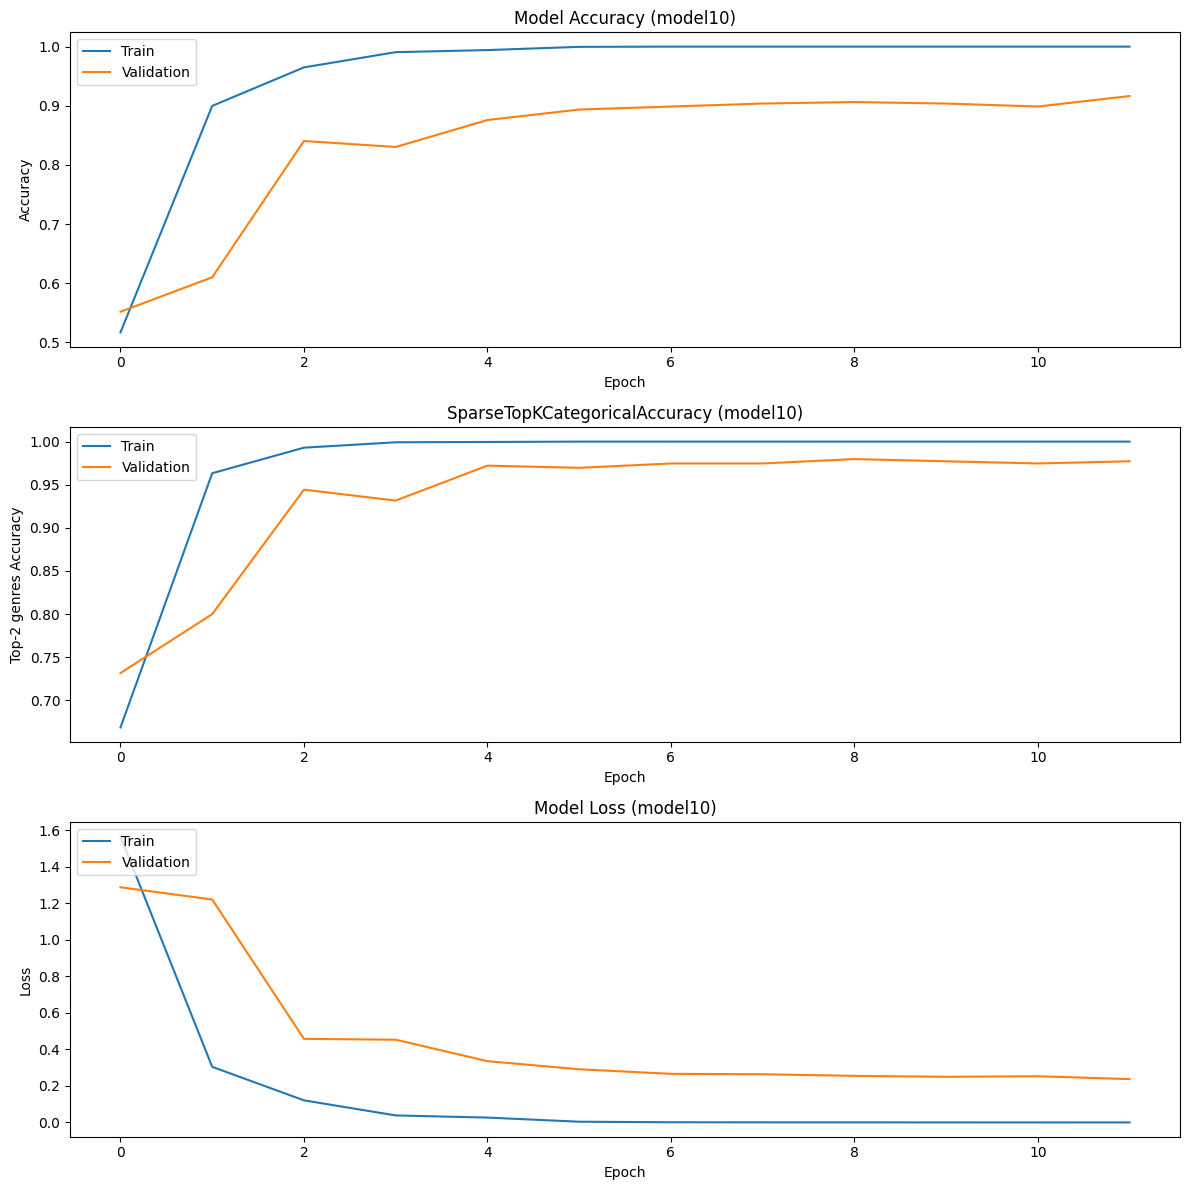

In [7]:
plot_history(history, 'model10')

In [8]:
evaluate_model(model, X_train, y_train, X_test, y_test, 'model10')

GTZAN Training Accuracy (model10): 100.00%
GTZAN Test Accuracy (model10): 91.65%
GTZAN Test top2 (model10): 97.72%


# MODEL12.h5

In [ ]:
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.utils import plot_model

from tensorflow.keras.regularizers import l2

def create_model(input_shape, l2_lambda=0.01):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, 
                     kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', 
                     kernel_regularizer=l2(l2_lambda))) 
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer=l2(l2_lambda)))

    model.add(Dense(10, activation='softmax', 
                    kernel_regularizer=l2(l2_lambda))) 

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(X_train[0].shape)

model.summary()


In [6]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print(f'X_train type: {X_train.dtype}, shape: {X_train.shape}')
print(f'y_train type: {y_train.dtype}, shape: {y_train.shape}')
print(f'X_test type: {X_test.dtype}, shape: {X_test.shape}')
print(f'y_test type: {y_test.dtype}, shape: {y_test.shape}')
print(f'X_train sample: {X_train[0,0,0,0]}') 

print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model11.h5')

X_train type: float32, shape: (4563, 256, 256, 1)
y_train type: int64, shape: (4563,)
X_test type: float32, shape: (395, 256, 256, 1)
y_test type: int64, shape: (395,)
X_train sample: 0.29411765933036804
Model input shape: (None, 256, 256, 1)


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/12


2024-04-11 21:49:06.409540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 21:49:07.946484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


  1/143 [..............................] - ETA: 6:26 - loss: 2.3065 - accuracy: 0.0625 - sparse_top_k_categorical_accuracy: 0.0938

2024-04-11 21:49:08.232906: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-11 21:49:08.232939: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


143/143 [==============================] - ETA: 0s - loss: 1.7168 - accuracy: 0.3960 - sparse_top_k_categorical_accuracy: 0.5617

2024-04-11 21:49:15.419617: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-11 21:49:15.419639: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


143/143 [==============================] - 10s 53ms/step - loss: 1.7168 - accuracy: 0.3960 - sparse_top_k_categorical_accuracy: 0.5617 - val_loss: 0.9382 - val_accuracy: 0.6506 - val_sparse_top_k_categorical_accuracy: 0.8152
Epoch 2/12
143/143 [==============================] - 8s 54ms/step - loss: 0.5508 - accuracy: 0.8214 - sparse_top_k_categorical_accuracy: 0.9275 - val_loss: 0.1737 - val_accuracy: 0.9570 - val_sparse_top_k_categorical_accuracy: 0.9924
Epoch 3/12
143/143 [==============================] - 8s 55ms/step - loss: 0.1208 - accuracy: 0.9719 - sparse_top_k_categorical_accuracy: 0.9952 - val_loss: 0.0201 - val_accuracy: 1.0000 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/12
143/143 [==============================] - 8s 55ms/step - loss: 0.0257 - accuracy: 0.9958 - sparse_top_k_categorical_accuracy: 0.9993 - val_loss: 0.0560 - val_accuracy: 0.9797 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/12
143/143 [==============================] - 8s 55ms/step - l

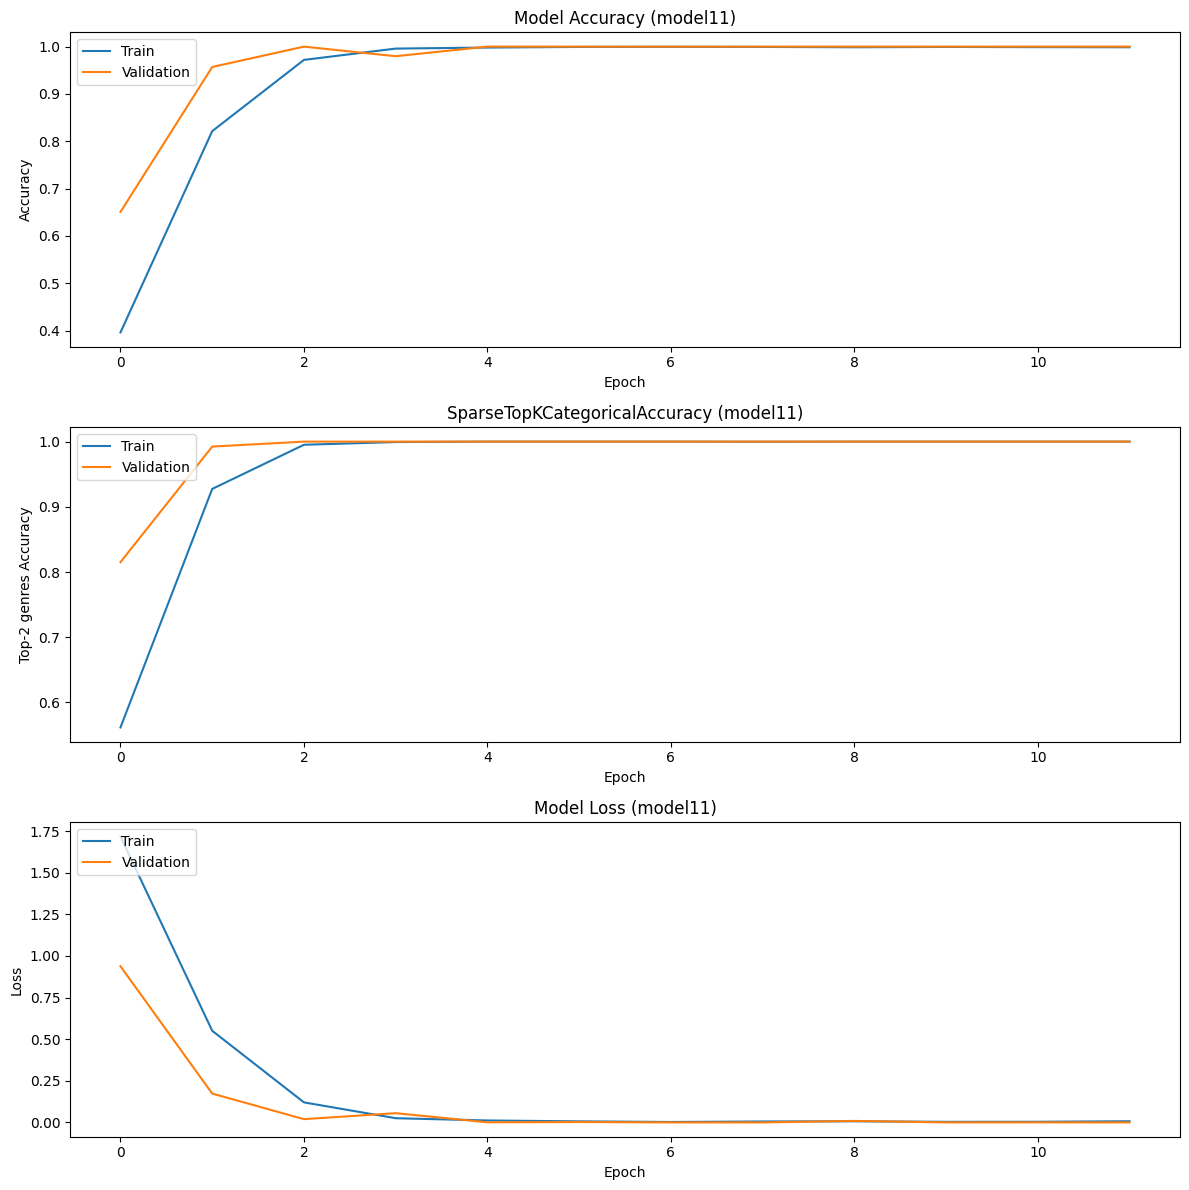

GTZAN Training Accuracy (model11): 99.96%
GTZAN Test Accuracy (model11): 100.00%
GTZAN Test top2 (model11): 100.00%


In [7]:
plot_history(history, 'model11')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model11')

# MODEL13.h5

In [4]:
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_delta=0.001, cooldown=1, verbose=1)

def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5)) 

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5)) 

    model.add(Dense(10, activation='softmax'))  # 10 genres

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(X_train[0].shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

2024-04-11 22:22:50.968954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 22:22:50.972275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 22:22:50.972636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 22:22:50.973217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 52

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_delta=0.001, cooldown=1, verbose=1)

def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[reduce_lr, early_stopping])

    return history

history = train_model(model, X_train, y_train, X_test, y_test)

model.save('final_final/model13.h5')

/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/52


2024-04-11 22:22:56.354721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 22:22:57.885759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


143/143 [==============================] - 11s 59ms/step - loss: 2.4621 - accuracy: 0.1442 - sparse_top_k_categorical_accuracy: 0.2707 - val_loss: 2.1551 - val_accuracy: 0.1797 - val_sparse_top_k_categorical_accuracy: 0.2532 - lr: 0.0010
Epoch 2/52
143/143 [==============================] - 8s 56ms/step - loss: 2.0693 - accuracy: 0.2330 - sparse_top_k_categorical_accuracy: 0.3859 - val_loss: 1.8949 - val_accuracy: 0.3671 - val_sparse_top_k_categorical_accuracy: 0.5316 - lr: 0.0010
Epoch 3/52
143/143 [==============================] - 8s 56ms/step - loss: 1.9729 - accuracy: 0.2658 - sparse_top_k_categorical_accuracy: 0.4425 - val_loss: 1.8158 - val_accuracy: 0.4152 - val_sparse_top_k_categorical_accuracy: 0.6228 - lr: 0.0010
Epoch 4/52
143/143 [==============================] - 8s 56ms/step - loss: 1.8838 - accuracy: 0.3007 - sparse_top_k_categorical_accuracy: 0.4810 - val_loss: 1.6759 - val_accuracy: 0.5038 - val_sparse_top_k_categorical_accuracy: 0.6481 - lr: 0.0010
Epoch 5/52
143/143

143/143 [==============================] - 8s 56ms/step - loss: 1.1170 - accuracy: 0.5825 - sparse_top_k_categorical_accuracy: 0.7451 - val_loss: 0.3340 - val_accuracy: 0.9848 - val_sparse_top_k_categorical_accuracy: 0.9975 - lr: 2.0000e-04
Epoch 34/52
143/143 [==============================] - 8s 58ms/step - loss: 1.0974 - accuracy: 0.5911 - sparse_top_k_categorical_accuracy: 0.7589 - val_loss: 0.3025 - val_accuracy: 0.9873 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 2.0000e-04
Epoch 35/52
142/143 [============================>.] - ETA: 0s - loss: 1.1023 - accuracy: 0.5827 - sparse_top_k_categorical_accuracy: 0.7557
Epoch 35: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
143/143 [==============================] - 8s 56ms/step - loss: 1.1042 - accuracy: 0.5821 - sparse_top_k_categorical_accuracy: 0.7552 - val_loss: 0.3081 - val_accuracy: 0.9899 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 2.0000e-04
Epoch 36/52
143/143 [=========================

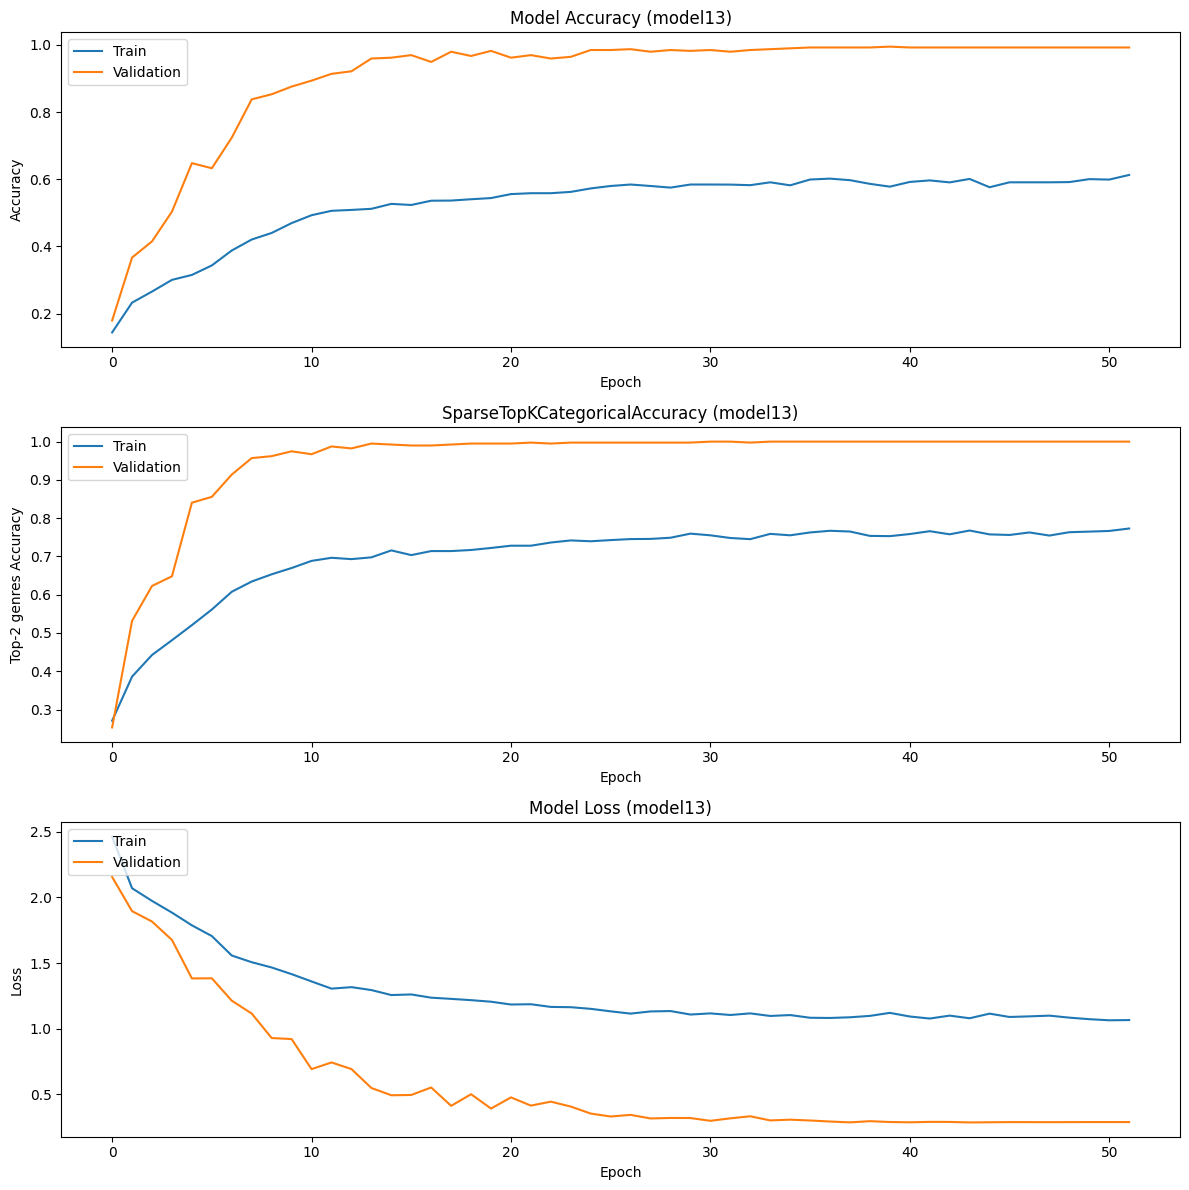

GTZAN Training Accuracy (model13): 98.93%
GTZAN Test Accuracy (model13): 99.24%
GTZAN Test top2 (model13): 100.00%


In [6]:
plot_history(history, 'model13')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model13')

# MODEL14.h5

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3)) 

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(0.3)) 

    model.add(Dense(10, activation='softmax'))  # 10 genres

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(X_train[0].shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 64)       

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 52

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_delta=0.001, cooldown=1, verbose=1)

def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[reduce_lr, early_stopping])

    return history

history = train_model(model, X_train, y_train, X_test, y_test)

model.save('final_final/model14.h5')

/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/52


2024-04-11 22:43:27.902582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 22:43:29.460985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-11 22:43:29.811302: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


143/143 [==============================] - 12s 61ms/step - loss: 2.1744 - accuracy: 0.2113 - sparse_top_k_categorical_accuracy: 0.3748 - val_loss: 1.9310 - val_accuracy: 0.3595 - val_sparse_top_k_categorical_accuracy: 0.4734 - lr: 0.0010
Epoch 2/52
143/143 [==============================] - 9s 63ms/step - loss: 1.6297 - accuracy: 0.4098 - sparse_top_k_categorical_accuracy: 0.6075 - val_loss: 1.1972 - val_accuracy: 0.6203 - val_sparse_top_k_categorical_accuracy: 0.7975 - lr: 0.0010
Epoch 3/52
143/143 [==============================] - 9s 62ms/step - loss: 1.2103 - accuracy: 0.5759 - sparse_top_k_categorical_accuracy: 0.7627 - val_loss: 0.9171 - val_accuracy: 0.6734 - val_sparse_top_k_categorical_accuracy: 0.8481 - lr: 0.0010
Epoch 4/52
143/143 [==============================] - 9s 62ms/step - loss: 1.0431 - accuracy: 0.6259 - sparse_top_k_categorical_accuracy: 0.8142 - val_loss: 1.3147 - val_accuracy: 0.5241 - val_sparse_top_k_categorical_accuracy: 0.6759 - lr: 0.0010
Epoch 5/52
143/143

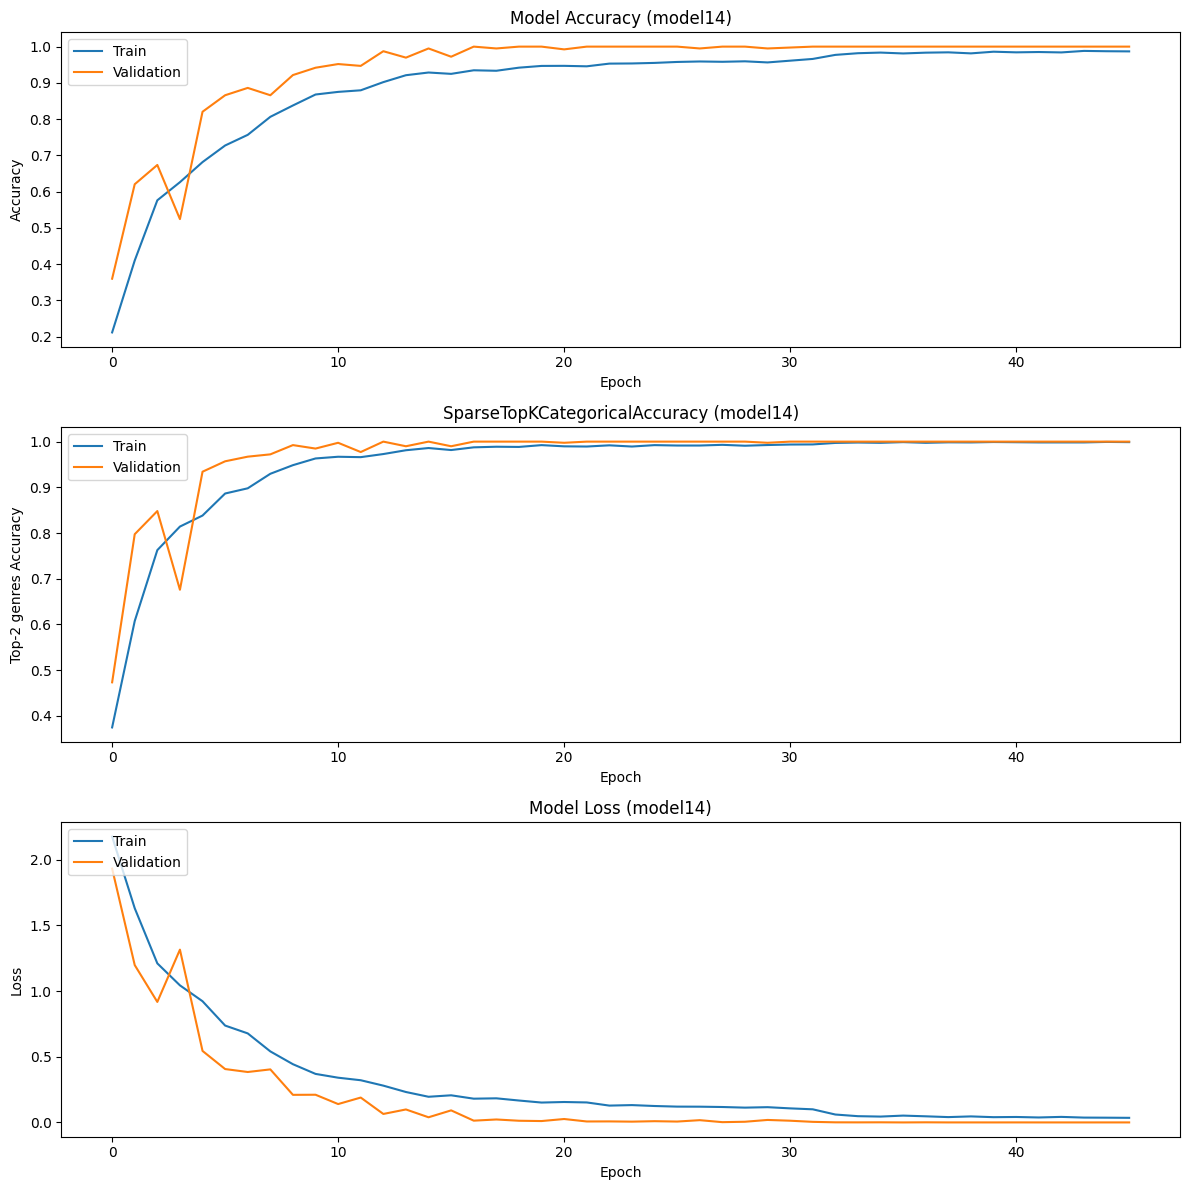

GTZAN Training Accuracy (model14): 99.96%
GTZAN Test Accuracy (model14): 100.00%
GTZAN Test top2 (model14): 100.00%


In [7]:
plot_history(history, 'model14')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model14')

# MODEL15.h5

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5)) 

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(0.5)) 

    model.add(Dense(10, activation='softmax'))  # 10 genres

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(X_train[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

2024-04-11 23:07:26.195633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 23:07:26.201686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 23:07:26.202384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 23:07:26.203345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 36

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_delta=0.001, cooldown=1, verbose=1)

def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[reduce_lr, early_stopping])

    return history

history = train_model(model, X_train, y_train, X_test, y_test)

model.save('final_final/model15.h5')

/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/36


2024-04-11 23:07:36.833509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 23:07:38.367039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 16s 66ms/step - loss: 2.4160 - accuracy: 0.1200 - sparse_top_k_categorical_accuracy: 0.2285 - val_loss: 2.1061 - val_accuracy: 0.2576 - val_sparse_top_k_categorical_accuracy: 0.4226 - lr: 0.0010
Epoch 2/36
196/196 [==============================] - 12s 63ms/step - loss: 1.8452 - accuracy: 0.3113 - sparse_top_k_categorical_accuracy: 0.5028 - val_loss: 1.8615 - val_accuracy: 0.3705 - val_sparse_top_k_categorical_accuracy: 0.6006 - lr: 0.0010
Epoch 3/36
196/196 [==============================] - 12s 63ms/step - loss: 1.4908 - accuracy: 0.4651 - sparse_top_k_categorical_accuracy: 0.6523 - val_loss: 1.6258 - val_accuracy: 0.3864 - val_sparse_top_k_categorical_accuracy: 0.5456 - lr: 0.0010
Epoch 4/36
196/196 [==============================] - 12s 63ms/step - loss: 1.2738 - accuracy: 0.5477 - sparse_top_k_categorical_accuracy: 0.7254 - val_loss: 1.3101 - val_accuracy: 0.5326 - val_sparse_top_k_categorical_accuracy: 0.7120 - lr: 0.0010
Epoch 5/36
196/

Epoch 32/36
196/196 [==============================] - 12s 63ms/step - loss: 0.0852 - accuracy: 0.9639 - sparse_top_k_categorical_accuracy: 0.9949 - val_loss: 7.9624e-04 - val_accuracy: 1.0000 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 8.0000e-06
Epoch 33/36
196/196 [==============================] - 12s 63ms/step - loss: 0.0916 - accuracy: 0.9615 - sparse_top_k_categorical_accuracy: 0.9947 - val_loss: 8.1593e-04 - val_accuracy: 1.0000 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 8.0000e-06
Epoch 34/36
196/196 [==============================] - 12s 63ms/step - loss: 0.0921 - accuracy: 0.9631 - sparse_top_k_categorical_accuracy: 0.9939 - val_loss: 7.9590e-04 - val_accuracy: 1.0000 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 8.0000e-06
Epoch 35/36
195/196 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9622 - sparse_top_k_categorical_accuracy: 0.9941
Epoch 35: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
196/196

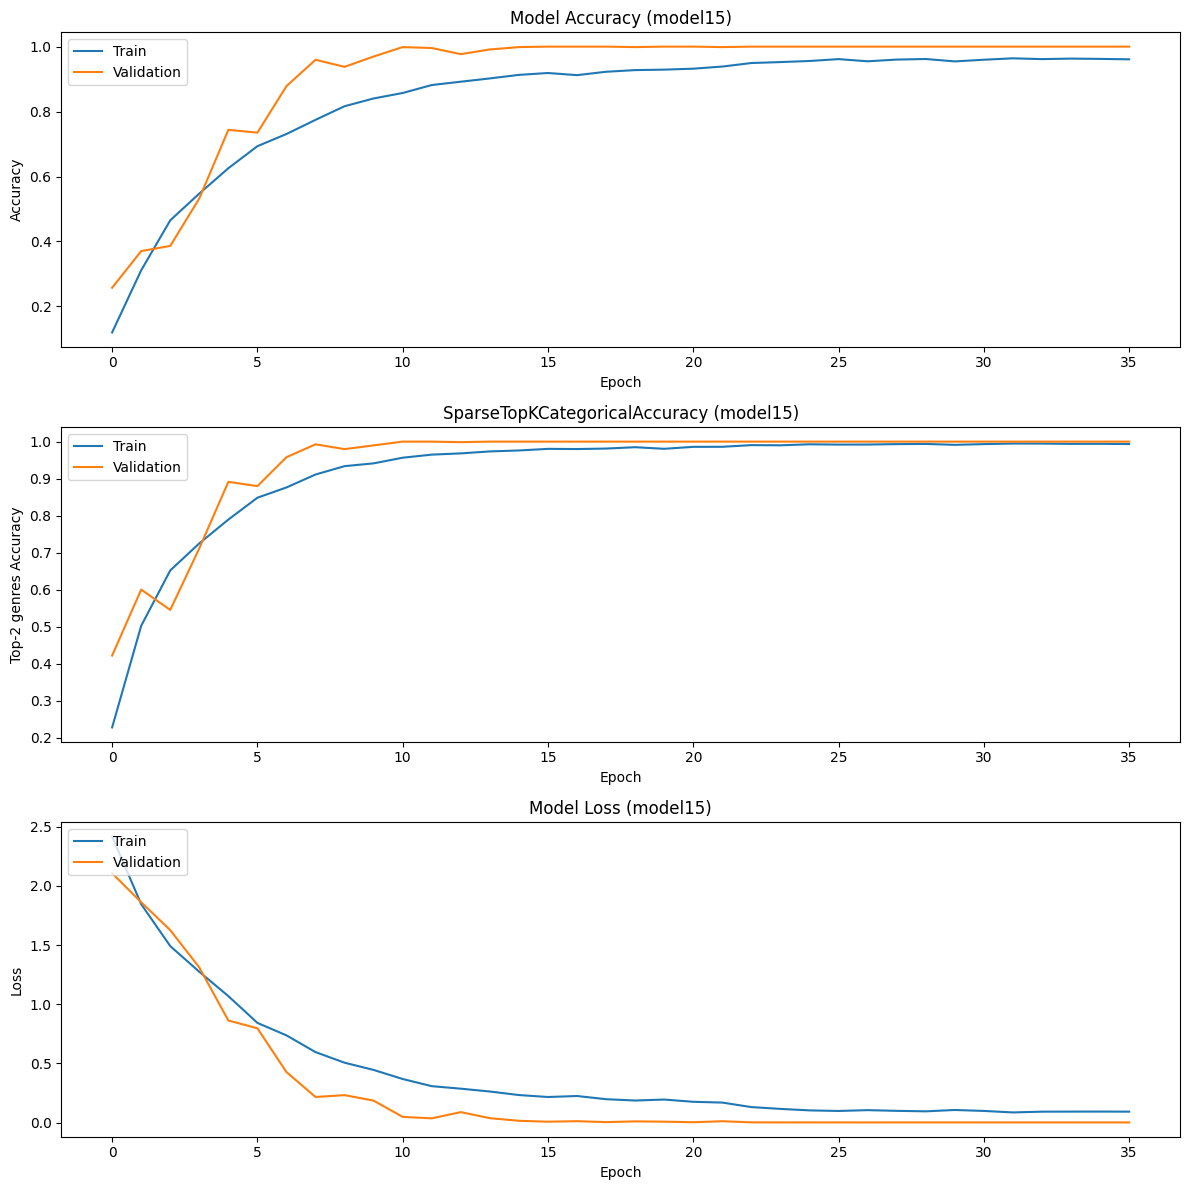

GTZAN Training Accuracy (model15): 99.97%
GTZAN Test Accuracy (model15): 100.00%
GTZAN Test top2 (model15): 100.00%


In [6]:
plot_history(history, 'model15')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model15')

# MODEL16.h5

In [4]:
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.utils import plot_model


def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.35))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.35))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.35))

    model.add(Dense(10, activation='softmax'))  # 10 genres

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(X_train[0].shape)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

2024-04-11 23:32:38.165032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 23:32:38.168619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 23:32:38.168995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 23:32:38.169618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [ ]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model16.h5')

X_train shape: (6537, 256, 256, 1)
y_train shape: (6537,)
X_test shape: (395, 256, 256, 1)
y_test shape: (395,)
Model input shape: (None, 256, 256, 1)


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/12


2024-04-11 23:32:44.823727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 23:32:46.306560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


205/205 [==============================] - 14s 58ms/step - loss: 2.4772 - accuracy: 0.0956 - sparse_top_k_categorical_accuracy: 0.2001 - val_loss: 2.3025 - val_accuracy: 0.1013 - val_sparse_top_k_categorical_accuracy: 0.2025
Epoch 2/12
205/205 [==============================] - 11s 56ms/step - loss: 2.3027 - accuracy: 0.0936 - sparse_top_k_categorical_accuracy: 0.1932 - val_loss: 2.3024 - val_accuracy: 0.1013 - val_sparse_top_k_categorical_accuracy: 0.2025
Epoch 3/12
205/205 [==============================] - 11s 56ms/step - loss: 2.3030 - accuracy: 0.0944 - sparse_top_k_categorical_accuracy: 0.1906 - val_loss: 2.3021 - val_accuracy: 0.1013 - val_sparse_top_k_categorical_accuracy: 0.2076
Epoch 4/12
205/205 [==============================] - 11s 55ms/step - loss: 2.3027 - accuracy: 0.0973 - sparse_top_k_categorical_accuracy: 0.1917 - val_loss: 2.3024 - val_accuracy: 0.1013 - val_sparse_top_k_categorical_accuracy: 0.2025
Epoch 5/12
205/205 [==============================] - 11s 55ms/step

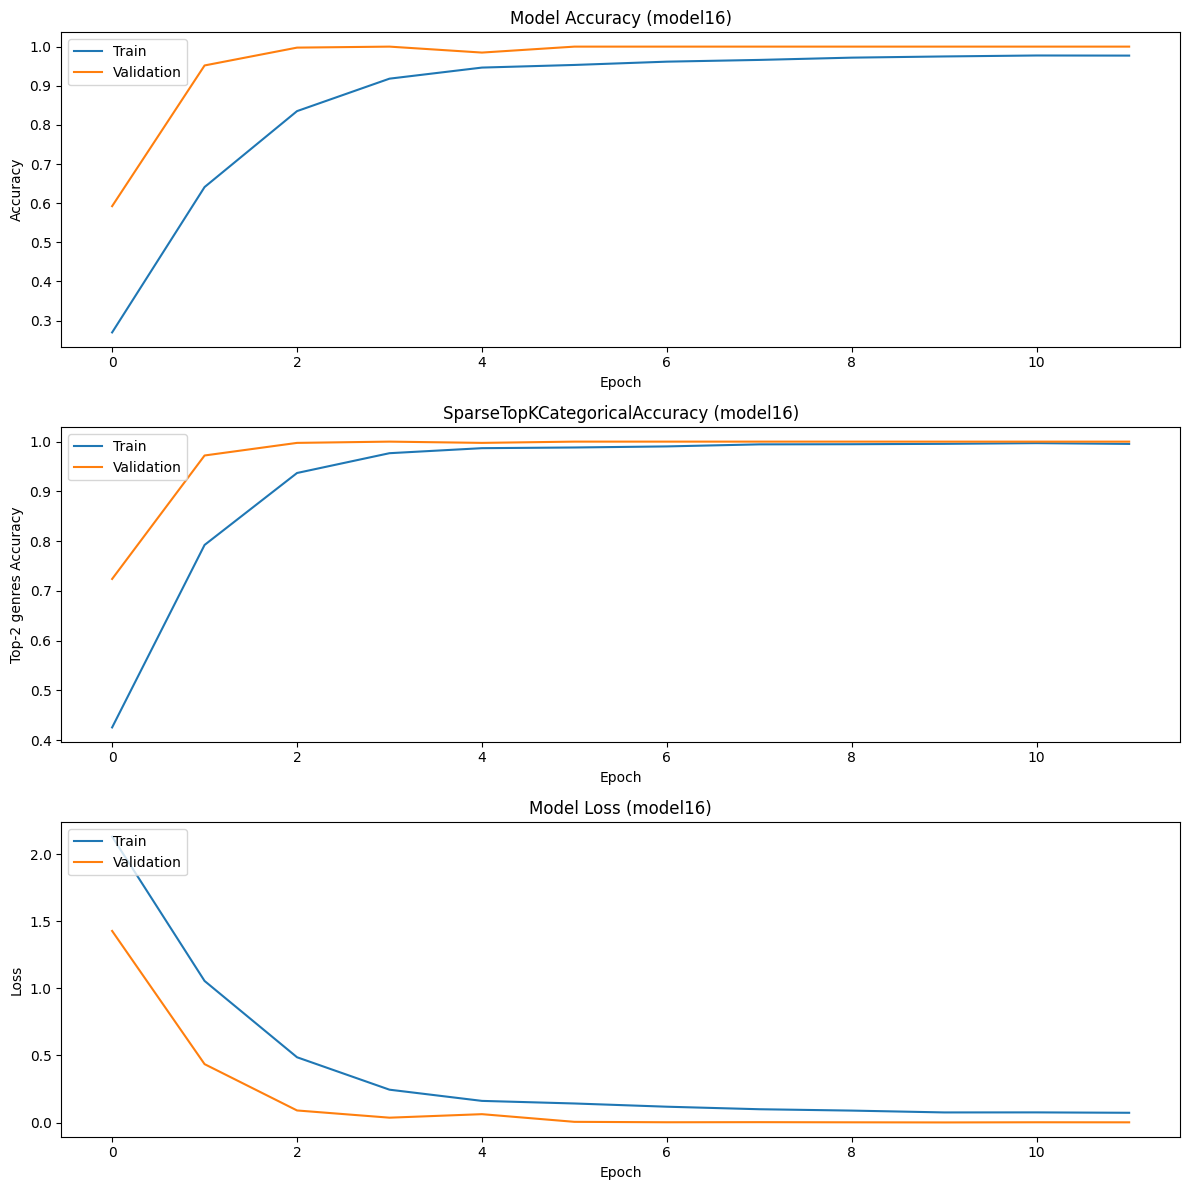

GTZAN Training Accuracy (model16): 99.94%
GTZAN Test Accuracy (model16): 100.00%
GTZAN Test top2 (model16): 100.00%


In [6]:
plot_history(history, 'model16')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model16')

# MODEL17.h5 - VGG16 TRANSFER LEARNING

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Flatten, Dense, Lambda
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
import tensorflow as tf

def create_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False,
                       input_shape=(input_shape[0], input_shape[1], 3))

    base_model.trainable = False

    model = Sequential()

    model.add(Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), input_shape=input_shape))

    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(input_shape=X_train[0].shape)
model.summary()

2024-04-11 23:40:05.319519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 23:40:05.325547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 23:40:05.326230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-11 23:40:05.327464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 16,812,554
Trainable params: 2,097,866
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model17.h5')

X_train shape: (6537, 256, 256, 1)
y_train shape: (6537,)
X_test shape: (395, 256, 256, 1)
y_test shape: (395,)
Model input shape: (None, 256, 256, 1)


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/12


2024-04-11 23:40:40.539331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-11 23:40:42.099943: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-11 23:40:42.099968: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-11 23:40:42.212766: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

205/205 [==============================] - 64s 286ms/step - loss: 1.2984 - accuracy: 0.5674 - sparse_top_k_categorical_accuracy: 0.7298 - val_loss: 0.7731 - val_accuracy: 0.7544 - val_sparse_top_k_categorical_accuracy: 0.9190
Epoch 2/12
205/205 [==============================] - 56s 272ms/step - loss: 0.6771 - accuracy: 0.7913 - sparse_top_k_categorical_accuracy: 0.9065 - val_loss: 0.4429 - val_accuracy: 0.8886 - val_sparse_top_k_categorical_accuracy: 0.9671
Epoch 3/12
205/205 [==============================] - 56s 273ms/step - loss: 0.4492 - accuracy: 0.8668 - sparse_top_k_categorical_accuracy: 0.9533 - val_loss: 0.3469 - val_accuracy: 0.9063 - val_sparse_top_k_categorical_accuracy: 0.9671
Epoch 4/12
205/205 [==============================] - 56s 272ms/step - loss: 0.3150 - accuracy: 0.9163 - sparse_top_k_categorical_accuracy: 0.9760 - val_loss: 0.2075 - val_accuracy: 0.9671 - val_sparse_top_k_categorical_accuracy: 0.9924
Epoch 5/12
205/205 [==============================] - 55s 271ms

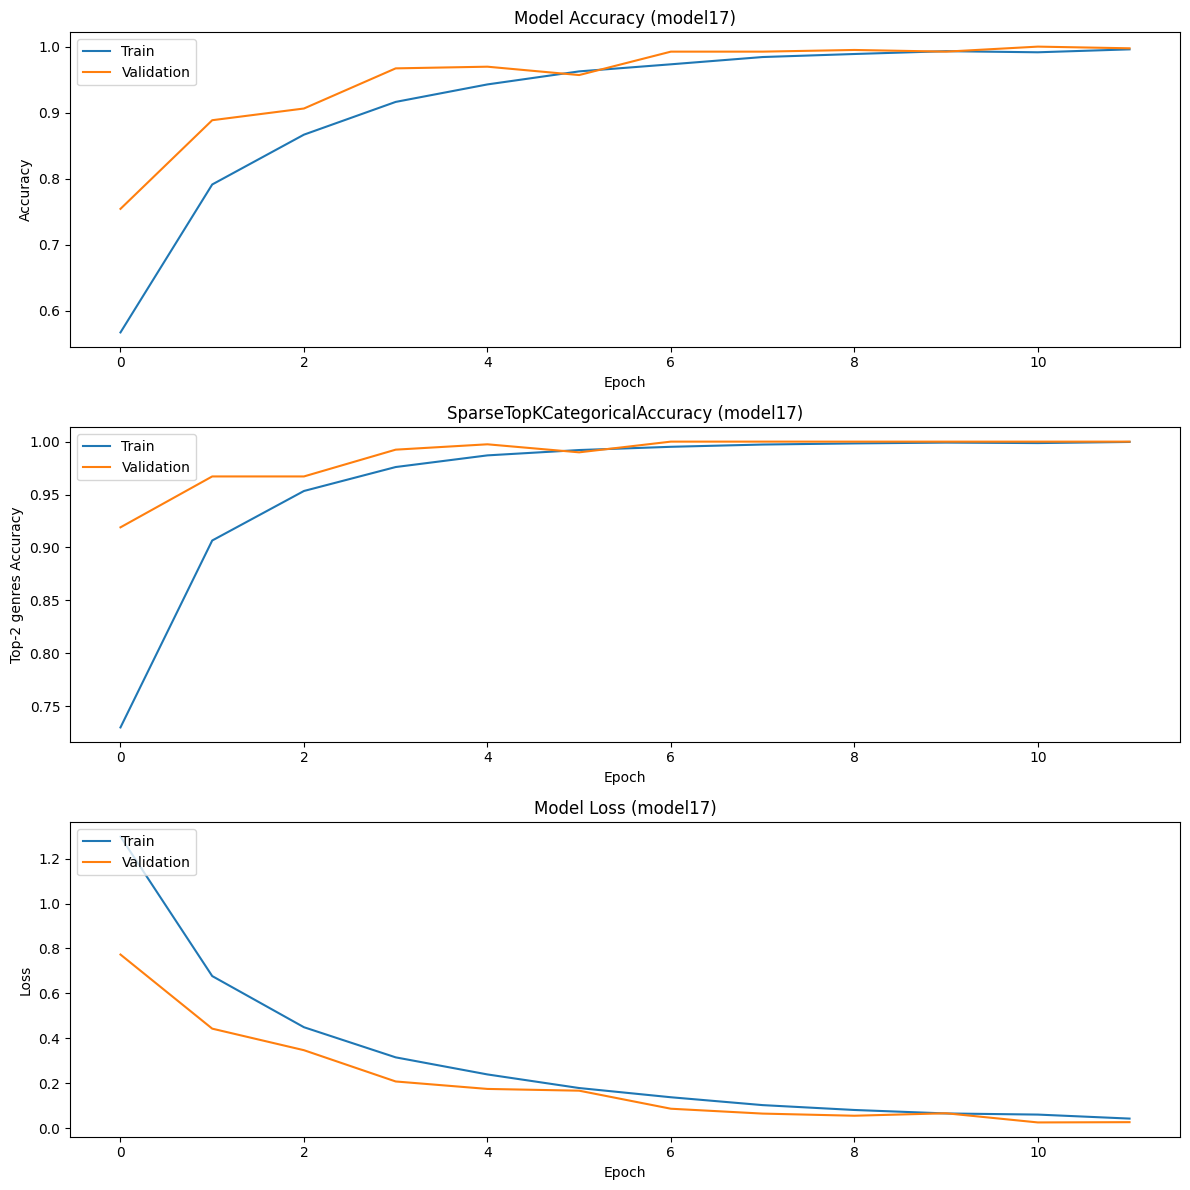

GTZAN Training Accuracy (model17): 99.66%
GTZAN Test Accuracy (model17): 99.75%
GTZAN Test top2 (model17): 100.00%


In [8]:
plot_history(history, 'model17')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model17')

# MODEL18.h5 - VGG16 FINE TUNING

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Lambda
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_model(input_shape, fine_tune_at=None):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))

    if fine_tune_at is not None:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    model = Sequential([
        Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), input_shape=input_shape),  # Adjust the input if necessary
        base_model,
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    return model

model = create_model(input_shape=X_train[0].shape, fine_tune_at=1)

adam_optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

model.summary()


2024-04-12 09:20:06.735779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 09:20:06.742006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 09:20:06.742704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 09:20:06.743655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 16,812,554
Trainable params: 16,812,554
Non-trainable params: 0
_________________________________________________________________


In [5]:
BATCH_SIZE=32
EPOCHS = 10

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model18.h5')

X_train shape: (6537, 256, 256, 1)
y_train shape: (6537,)
X_test shape: (395, 256, 256, 1)
y_test shape: (395,)
Model input shape: (None, 256, 256, 1)


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10


2024-04-12 09:20:15.006948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-12 09:20:16.581780: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-12 09:20:16.581805: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-12 09:20:16.694865: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

205/205 [==============================] - 64s 289ms/step - loss: 1.0012 - accuracy: 0.6529 - sparse_top_k_categorical_accuracy: 0.8034 - val_loss: 0.6161 - val_accuracy: 0.7823 - val_sparse_top_k_categorical_accuracy: 0.9190
Epoch 2/10
205/205 [==============================] - 57s 276ms/step - loss: 0.3895 - accuracy: 0.8654 - sparse_top_k_categorical_accuracy: 0.9544 - val_loss: 0.3967 - val_accuracy: 0.8481 - val_sparse_top_k_categorical_accuracy: 0.9595
Epoch 3/10
205/205 [==============================] - 57s 276ms/step - loss: 0.2003 - accuracy: 0.9338 - sparse_top_k_categorical_accuracy: 0.9856 - val_loss: 0.1056 - val_accuracy: 0.9595 - val_sparse_top_k_categorical_accuracy: 0.9899
Epoch 4/10
205/205 [==============================] - 57s 279ms/step - loss: 0.1046 - accuracy: 0.9676 - sparse_top_k_categorical_accuracy: 0.9933 - val_loss: 0.0711 - val_accuracy: 0.9671 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/10
205/205 [==============================] - 57s 277ms

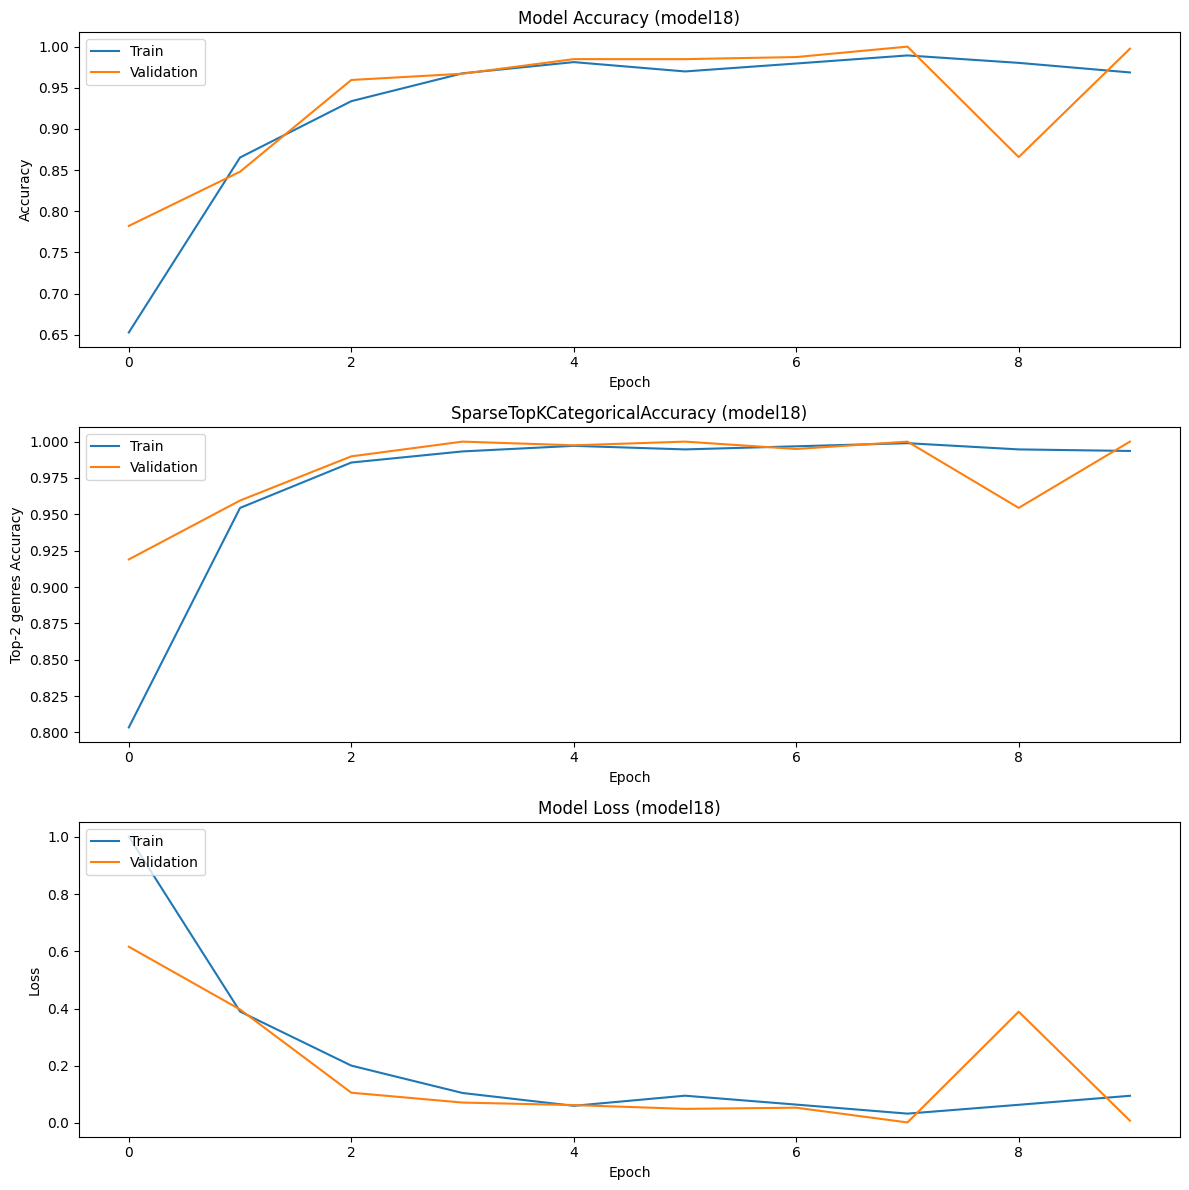

GTZAN Training Accuracy (model18): 99.22%
GTZAN Test Accuracy (model18): 99.75%
GTZAN Test top2 (model18): 100.00%


In [6]:
plot_history(history, 'model18')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model18')

# MODEL19.h5 - MobileNet TRANSFER LEARNING

In [4]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Flatten, Dense, Lambda
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
import tensorflow as tf

def create_model(input_shape):
    base_model = MobileNet(weights='imagenet', include_top=False,
                           input_shape=(input_shape[0], input_shape[1], 3))

    base_model.trainable = False

    model = Sequential()

    if input_shape[2] == 1:
        model.add(Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), input_shape=input_shape))

    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(input_shape=X_train[0].shape)
model.summary()

2024-04-12 09:35:46.874776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 09:35:46.880213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 09:35:46.880826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 09:35:46.881732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 64)                4194368   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 7,423,882
Trainable params: 4,195,018
Non-trainable params: 3,228,864
______________________________________

In [5]:
model = create_model(X_train[0].shape)

BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model19.h5')

X_train shape: (6537, 256, 256, 1)
y_train shape: (6537,)
X_test shape: (395, 256, 256, 1)
y_test shape: (395,)
Model input shape: (None, 256, 256, 1)


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/12


2024-04-12 09:39:36.877160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-12 09:39:38.230783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


205/205 [==============================] - 25s 111ms/step - loss: 1.5135 - accuracy: 0.7468 - sparse_top_k_categorical_accuracy: 0.8637 - val_loss: 0.0914 - val_accuracy: 0.9646 - val_sparse_top_k_categorical_accuracy: 0.9949
Epoch 2/12
205/205 [==============================] - 22s 107ms/step - loss: 0.1004 - accuracy: 0.9688 - sparse_top_k_categorical_accuracy: 0.9948 - val_loss: 0.0474 - val_accuracy: 0.9848 - val_sparse_top_k_categorical_accuracy: 0.9949
Epoch 3/12
205/205 [==============================] - 22s 106ms/step - loss: 0.0414 - accuracy: 0.9888 - sparse_top_k_categorical_accuracy: 0.9991 - val_loss: 0.0142 - val_accuracy: 0.9975 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/12
205/205 [==============================] - 22s 108ms/step - loss: 0.0166 - accuracy: 0.9962 - sparse_top_k_categorical_accuracy: 0.9998 - val_loss: 0.0197 - val_accuracy: 0.9949 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/12
205/205 [==============================] - 21s 102ms

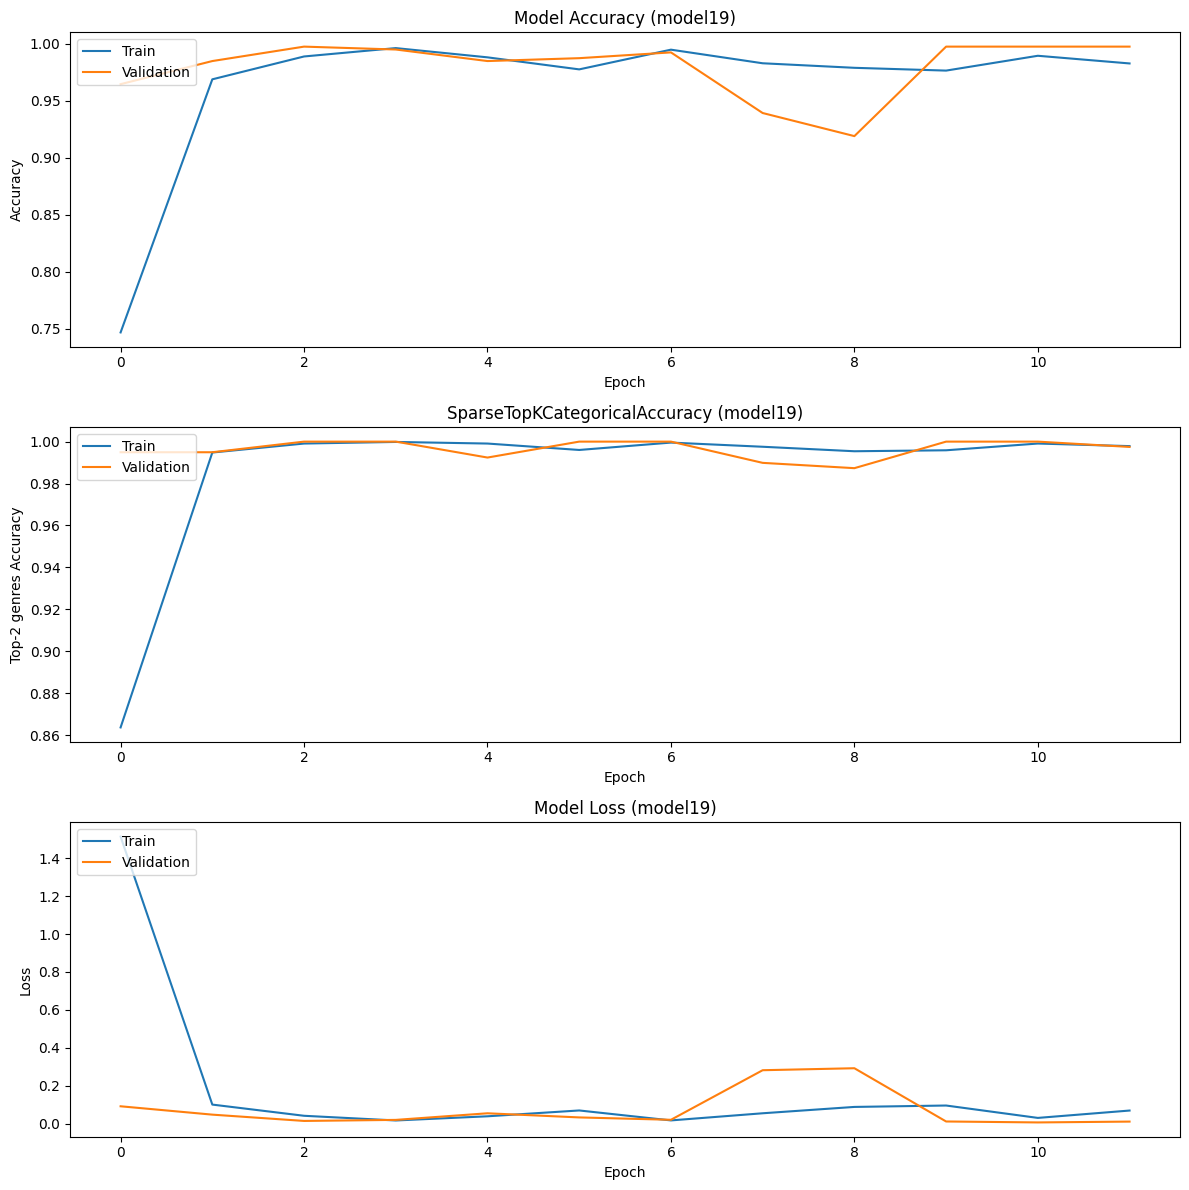

In [ ]:
plot_history(history, 'model19')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model19')

# MODEL20.h5 - MobileNet FINE TUNING

In [4]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Lambda
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_model(input_shape, fine_tune_at=None):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))

    if fine_tune_at is not None:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    model = Sequential([
        Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), input_shape=input_shape),  # Adjust the input if necessary
        base_model,
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    return model

model = create_model(input_shape=X_train[0].shape, fine_tune_at=1)

adam_optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

model.summary()

2024-04-12 09:48:18.627717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 09:48:18.633647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 09:48:18.634345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 09:48:18.635339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 64)                4194368   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 7,423,882
Trainable params: 7,401,994
Non-trainable params: 21,888
_________________________________________

In [5]:
BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model20.h5')

X_train shape: (6537, 256, 256, 1)
y_train shape: (6537,)
X_test shape: (395, 256, 256, 1)
y_test shape: (395,)
Model input shape: (None, 256, 256, 1)


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/12


2024-04-12 09:49:44.807718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-12 09:49:46.161963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


205/205 [==============================] - 34s 154ms/step - loss: 0.8277 - accuracy: 0.7314 - sparse_top_k_categorical_accuracy: 0.8498 - val_loss: 1.0436 - val_accuracy: 0.7013 - val_sparse_top_k_categorical_accuracy: 0.8278
Epoch 2/12
205/205 [==============================] - 31s 153ms/step - loss: 0.0558 - accuracy: 0.9835 - sparse_top_k_categorical_accuracy: 0.9977 - val_loss: 0.1790 - val_accuracy: 0.9367 - val_sparse_top_k_categorical_accuracy: 0.9797
Epoch 3/12
205/205 [==============================] - 31s 153ms/step - loss: 0.0159 - accuracy: 0.9977 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 0.0116 - val_accuracy: 0.9975 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/12
205/205 [==============================] - 32s 157ms/step - loss: 0.0097 - accuracy: 0.9985 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/12
205/205 [==============================] - 32s 154ms

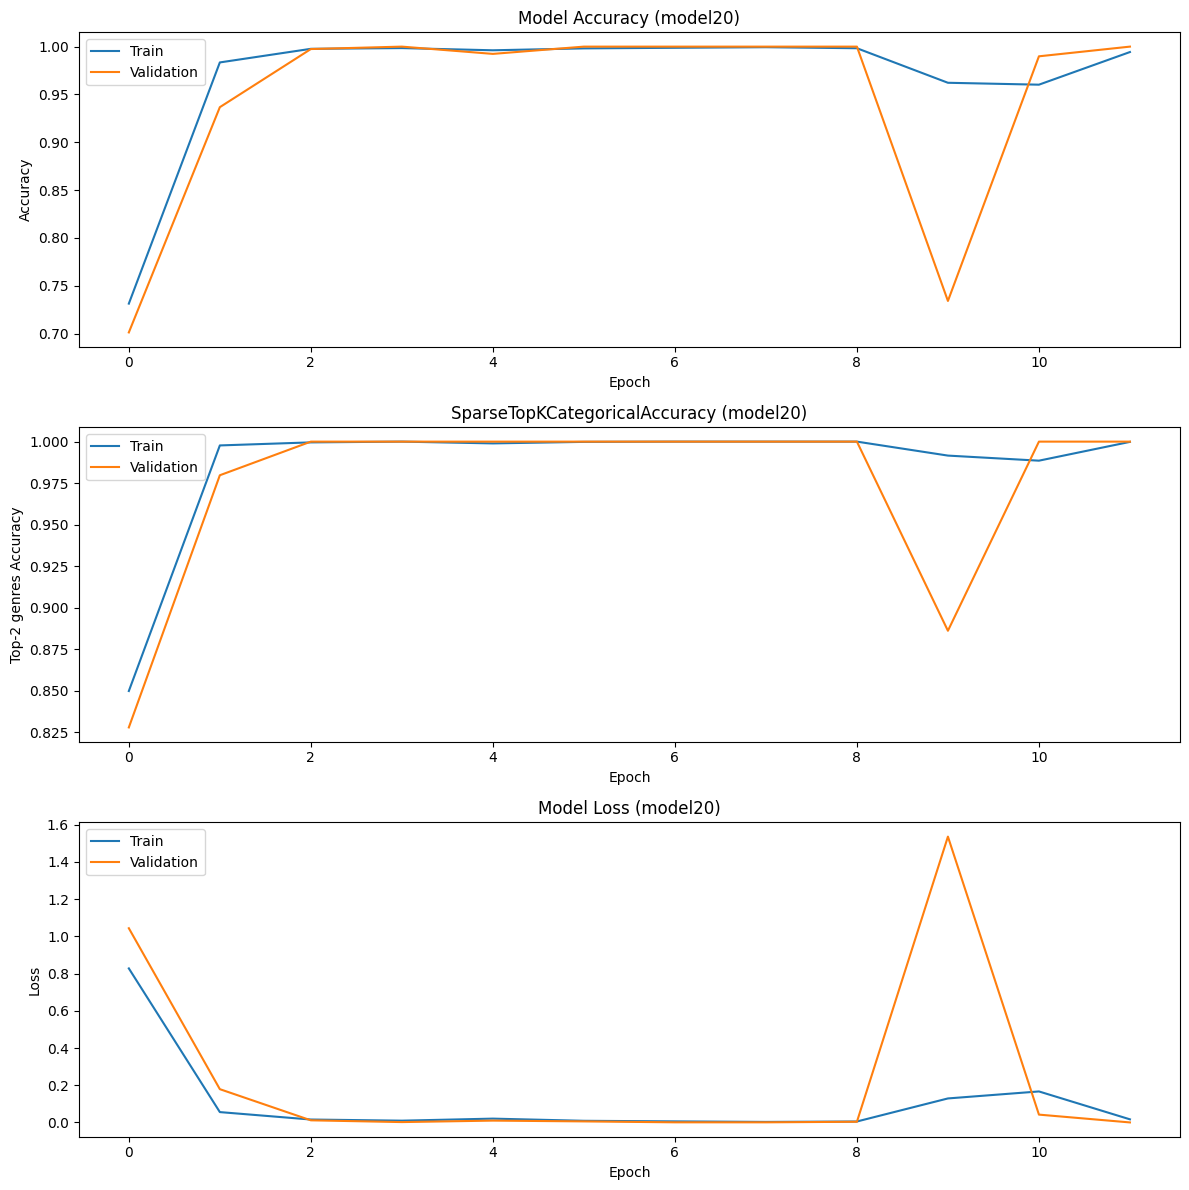

GTZAN Training Accuracy (model20): 99.83%
GTZAN Test Accuracy (model20): 100.00%
GTZAN Test top2 (model20): 100.00%


In [6]:
plot_history(history, 'model20')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model20')

# MODEL21.h5 - Resnet50 TRANSFER LEARNING

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Flatten, Dense, Lambda, GlobalAveragePooling2D
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
import tensorflow as tf

def create_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))

    base_model.trainable = False

    model = Sequential()

    if input_shape[2] == 1:
        model.add(Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), input_shape=input_shape))

    model.add(base_model)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))  # 10 genres

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(input_shape=X_train[0].shape)

model.summary()

2024-04-12 10:23:03.523521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 10:23:03.529601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 10:23:03.530301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 10:23:03.531218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 527,114
Non-trainable params: 23,587,712
______________________________________

In [5]:
BATCH_SIZE=32
EPOCHS = 50

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model21.h5')

X_train shape: (6537, 256, 256, 1)
y_train shape: (6537,)
X_test shape: (395, 256, 256, 1)
y_test shape: (395,)
Model input shape: (None, 256, 256, 1)


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50


2024-04-12 10:23:14.772999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-12 10:23:16.223217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


205/205 [==============================] - 41s 186ms/step - loss: 2.2997 - accuracy: 0.1504 - sparse_top_k_categorical_accuracy: 0.2738 - val_loss: 2.1806 - val_accuracy: 0.1873 - val_sparse_top_k_categorical_accuracy: 0.3114
Epoch 2/50
205/205 [==============================] - 38s 185ms/step - loss: 2.1051 - accuracy: 0.2062 - sparse_top_k_categorical_accuracy: 0.3708 - val_loss: 2.1071 - val_accuracy: 0.1747 - val_sparse_top_k_categorical_accuracy: 0.3823
Epoch 3/50
205/205 [==============================] - 39s 189ms/step - loss: 1.9808 - accuracy: 0.2555 - sparse_top_k_categorical_accuracy: 0.4407 - val_loss: 1.9406 - val_accuracy: 0.2430 - val_sparse_top_k_categorical_accuracy: 0.4886
Epoch 4/50
205/205 [==============================] - 38s 188ms/step - loss: 1.9082 - accuracy: 0.2770 - sparse_top_k_categorical_accuracy: 0.4712 - val_loss: 1.8924 - val_accuracy: 0.2709 - val_sparse_top_k_categorical_accuracy: 0.4709
Epoch 5/50
205/205 [==============================] - 38s 186ms

205/205 [==============================] - 38s 185ms/step - loss: 1.3894 - accuracy: 0.5033 - sparse_top_k_categorical_accuracy: 0.6997 - val_loss: 1.3627 - val_accuracy: 0.5089 - val_sparse_top_k_categorical_accuracy: 0.7089
Epoch 36/50
205/205 [==============================] - 38s 186ms/step - loss: 1.4113 - accuracy: 0.4961 - sparse_top_k_categorical_accuracy: 0.6869 - val_loss: 1.3923 - val_accuracy: 0.4886 - val_sparse_top_k_categorical_accuracy: 0.7063
Epoch 37/50
205/205 [==============================] - 39s 189ms/step - loss: 1.3977 - accuracy: 0.5028 - sparse_top_k_categorical_accuracy: 0.6931 - val_loss: 1.4198 - val_accuracy: 0.5063 - val_sparse_top_k_categorical_accuracy: 0.6886
Epoch 38/50
205/205 [==============================] - 37s 182ms/step - loss: 1.3833 - accuracy: 0.5106 - sparse_top_k_categorical_accuracy: 0.6905 - val_loss: 1.3179 - val_accuracy: 0.5063 - val_sparse_top_k_categorical_accuracy: 0.7468
Epoch 39/50
205/205 [==============================] - 38s 1

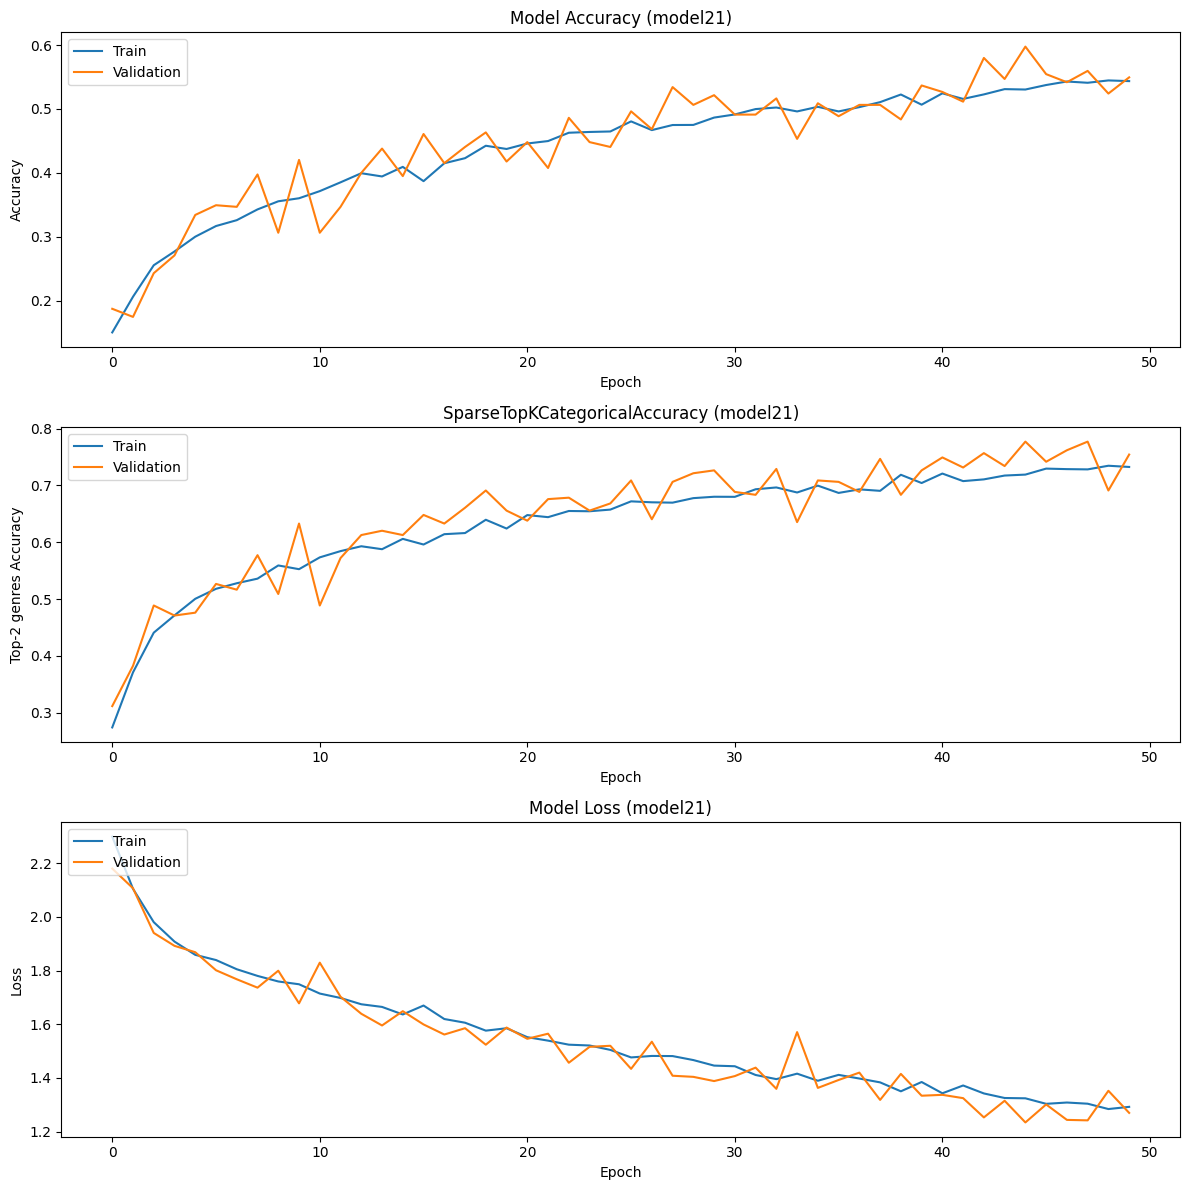

GTZAN Training Accuracy (model21): 55.84%
GTZAN Test Accuracy (model21): 54.94%
GTZAN Test top2 (model21): 75.44%


In [6]:
plot_history(history, 'model21')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model21')

# MODEL22.h5 - MOBILE NET TRANSFER LEARNING with RGB and LR decay

In [6]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_model(input_shape):
    base_model = MobileNet(weights='imagenet', include_top=False,
                           input_shape=(input_shape[0], input_shape[1], 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    def custom_lr_schedule(epoch):
        initial_lr = 0.001
        decay_rate = 0.96
        decay_step = 100000
        min_lr = 1e-5
        lr = initial_lr * (decay_rate ** (epoch / decay_step))
        return max(lr, min_lr)  # Ensure lr does not fall below min_lr

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(custom_lr_schedule)

    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model, lr_scheduler


model, lr_scheduler = create_model(input_shape=X_train[0].shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4194368   
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 7,423,882
Trainable params: 4,195,018
Non-trainable params: 3,228,864
_________________________________________________________________


In [9]:
BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler])

    return history

history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model22.h5')

X_train shape: (6537, 256, 256, 3)
y_train shape: (6537,)
X_test shape: (395, 256, 256, 3)
y_test shape: (395,)
Model input shape: (None, 256, 256, 3)


2024-04-12 11:22:53.986763: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5140905984 exceeds 10% of free system memory.
/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-12 11:22:55.104206: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5140905984 exceeds 10% of free system memory.


Epoch 1/12


2024-04-12 11:22:56.615611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-12 11:22:58.009244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


205/205 [==============================] - 25s 112ms/step - loss: 1.6244 - accuracy: 0.5495 - sparse_top_k_categorical_accuracy: 0.7219 - val_loss: 0.5544 - val_accuracy: 0.8177 - val_sparse_top_k_categorical_accuracy: 0.9089 - lr: 0.0010
Epoch 2/12
205/205 [==============================] - 23s 113ms/step - loss: 0.2782 - accuracy: 0.9110 - sparse_top_k_categorical_accuracy: 0.9693 - val_loss: 0.0804 - val_accuracy: 0.9823 - val_sparse_top_k_categorical_accuracy: 0.9949 - lr: 1.0000e-03
Epoch 3/12
205/205 [==============================] - 23s 110ms/step - loss: 0.0578 - accuracy: 0.9855 - sparse_top_k_categorical_accuracy: 0.9969 - val_loss: 0.0211 - val_accuracy: 0.9949 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 1.0000e-03
Epoch 4/12
205/205 [==============================] - 20s 96ms/step - loss: 0.0183 - accuracy: 0.9977 - sparse_top_k_categorical_accuracy: 0.9997 - val_loss: 0.0076 - val_accuracy: 1.0000 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 1.0000e-03


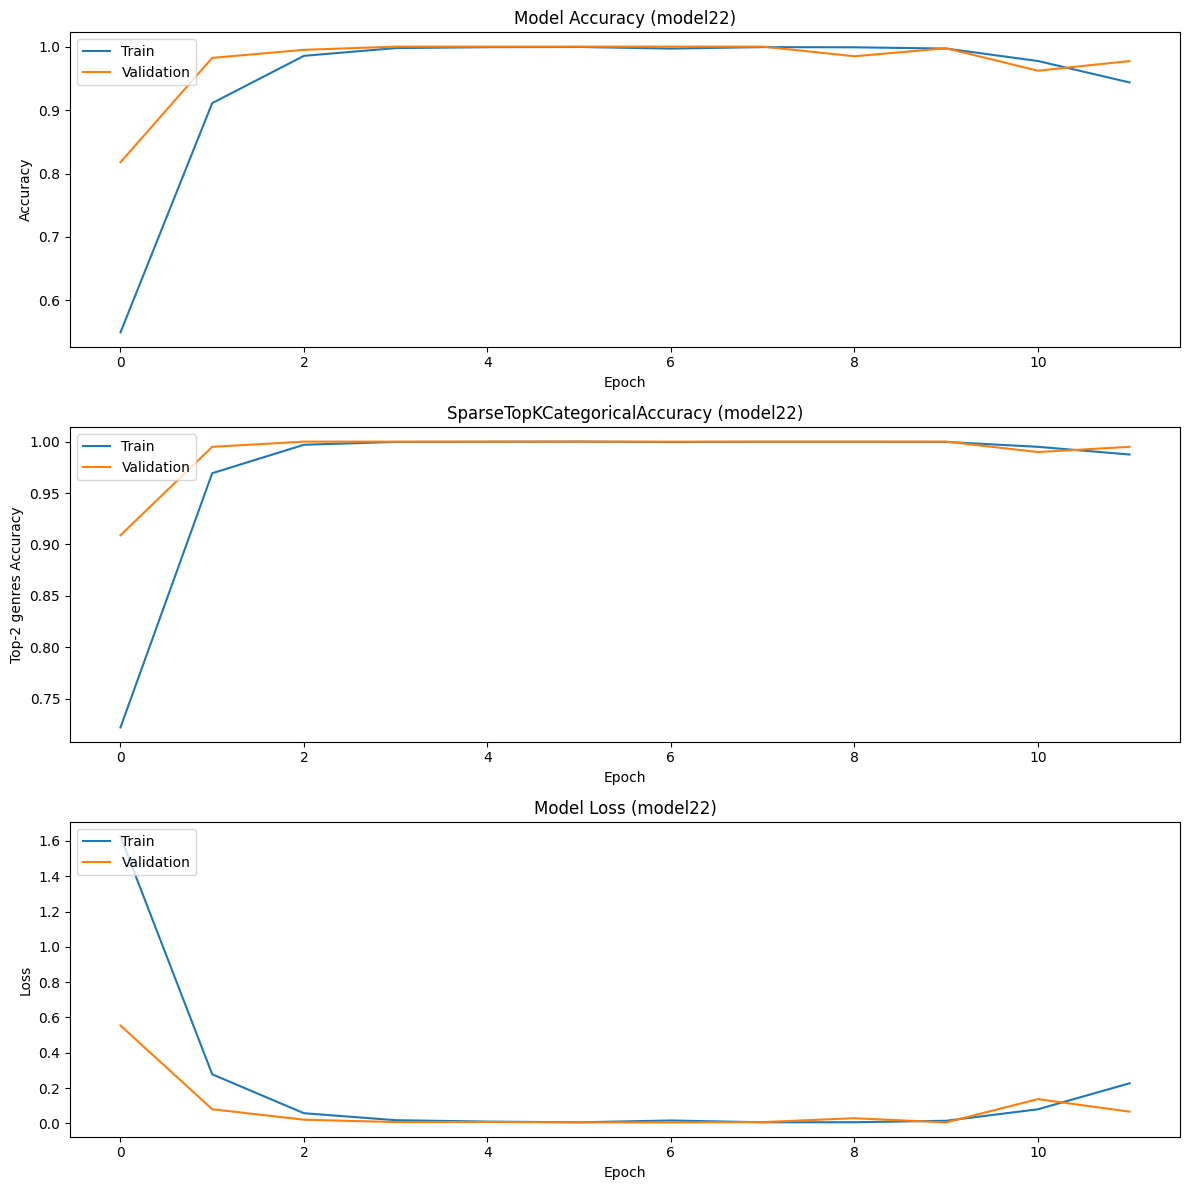

2024-04-12 11:27:33.820144: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5140905984 exceeds 10% of free system memory.
2024-04-12 11:27:34.913446: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5140905984 exceeds 10% of free system memory.


GTZAN Training Accuracy (model22): 98.29%
GTZAN Test Accuracy (model22): 97.72%
GTZAN Test top2 (model22): 99.49%


In [10]:
plot_history(history, 'model22')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model22')

# MODEL23.h5 - MOBILE NET FINE TUNING with RGB and LR decay

In [5]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_model(input_shape, fine_tune_at=None):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))

    if fine_tune_at is not None:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    model = Sequential([
        base_model, 
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    return model

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,  
    decay_rate=0.96,
    staircase=True)

adam_optimizer = Adam(learning_rate=lr_schedule)

model = create_model(input_shape=X_train[0].shape, fine_tune_at=1)
model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4194368   
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 7,423,882
Trainable params: 7,401,994
Non-trainable params: 21,888
_________________________________________________________________


In [6]:
BATCH_SIZE=32
EPOCHS = 12

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)


def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])
    return history

history = train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE)
model.save('final_final/model23.h5')

X_train shape: (6537, 256, 256, 3)
y_train shape: (6537,)
X_test shape: (395, 256, 256, 3)
y_test shape: (395,)
Model input shape: (None, 256, 256, 3)


2024-04-12 11:36:32.362363: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5140905984 exceeds 10% of free system memory.
/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-12 11:36:33.512124: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5140905984 exceeds 10% of free system memory.


Epoch 1/12


2024-04-12 11:36:35.121051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-12 11:36:36.450287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


205/205 [==============================] - 35s 157ms/step - loss: 0.8106 - accuracy: 0.7444 - sparse_top_k_categorical_accuracy: 0.8472 - val_loss: 0.1567 - val_accuracy: 0.9570 - val_sparse_top_k_categorical_accuracy: 0.9873 - lr: 1.0000e-04
Epoch 2/12
205/205 [==============================] - 32s 155ms/step - loss: 0.0531 - accuracy: 0.9867 - sparse_top_k_categorical_accuracy: 0.9969 - val_loss: 0.0151 - val_accuracy: 0.9949 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/12
205/205 [==============================] - 32s 155ms/step - loss: 0.0174 - accuracy: 0.9972 - sparse_top_k_categorical_accuracy: 0.9997 - val_loss: 0.0041 - val_accuracy: 1.0000 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/12
205/205 [==============================] - 32s 156ms/step - loss: 0.0126 - accuracy: 0.9971 - sparse_top_k_categorical_accuracy: 0.9997 - val_loss: 0.0053 - val_accuracy: 0.9975 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 1.0000

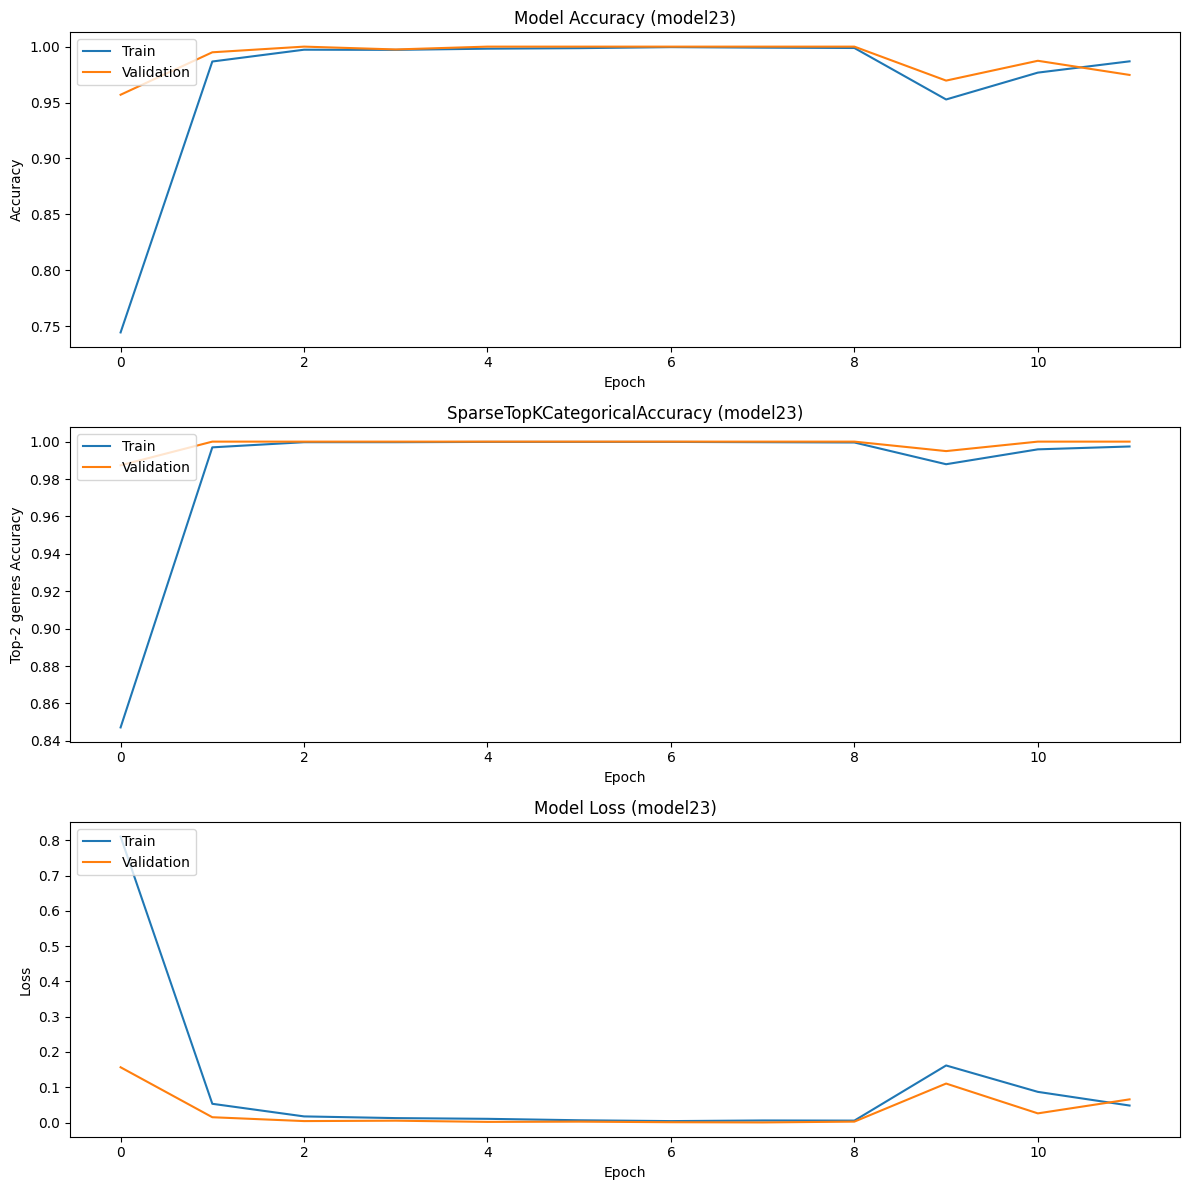

2024-04-12 11:43:50.086823: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5140905984 exceeds 10% of free system memory.
2024-04-12 11:43:51.187250: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5140905984 exceeds 10% of free system memory.


GTZAN Training Accuracy (model23): 98.62%
GTZAN Test Accuracy (model23): 97.47%
GTZAN Test top2 (model23): 100.00%


In [7]:
plot_history(history, 'model23')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model23')

# MODEL24.h5 - Resnet50 Transfer learning - 150 epoch and LR decay

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Flatten, Dense, Lambda, GlobalAveragePooling2D
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
import tensorflow as tf

def create_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))

    base_model.trainable = False

    model = Sequential()

    if input_shape[2] == 1:
        model.add(Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), input_shape=input_shape))

    model.add(base_model)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))  # 10 genres

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=2)])

    return model

model = create_model(input_shape=X_train[0].shape)

model.summary()

2024-04-12 13:18:23.931628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 13:18:23.937739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 13:18:23.938434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 13:18:23.939305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 527,114
Non-trainable params: 23,587,712
______________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BATCH_SIZE=32
EPOCHS = 200

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('Model input shape:', model.input_shape)

def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,              
        patience=5,              
        min_lr=0.0001,           
        verbose=1              
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )

    return history
history = train_model(model, X_train, y_train, X_test, y_test)
model.save('final_final/model24.h5')

X_train shape: (6537, 256, 256, 1)
y_train shape: (6537,)
X_test shape: (395, 256, 256, 1)
y_test shape: (395,)
Model input shape: (None, 256, 256, 1)


/home/fipulab/anaconda3/envs/music-tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/200


2024-04-12 13:19:05.477953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-12 13:19:06.813048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


205/205 [==============================] - 42s 190ms/step - loss: 2.3069 - accuracy: 0.1444 - sparse_top_k_categorical_accuracy: 0.2648 - val_loss: 2.1604 - val_accuracy: 0.2127 - val_sparse_top_k_categorical_accuracy: 0.3975 - lr: 0.0010
Epoch 2/200
205/205 [==============================] - 39s 189ms/step - loss: 2.0903 - accuracy: 0.2229 - sparse_top_k_categorical_accuracy: 0.3875 - val_loss: 1.9882 - val_accuracy: 0.2684 - val_sparse_top_k_categorical_accuracy: 0.4886 - lr: 0.0010
Epoch 3/200
205/205 [==============================] - 38s 187ms/step - loss: 1.9767 - accuracy: 0.2605 - sparse_top_k_categorical_accuracy: 0.4464 - val_loss: 1.9289 - val_accuracy: 0.2481 - val_sparse_top_k_categorical_accuracy: 0.4886 - lr: 0.0010
Epoch 4/200
205/205 [==============================] - 39s 189ms/step - loss: 1.9053 - accuracy: 0.2720 - sparse_top_k_categorical_accuracy: 0.4721 - val_loss: 1.8749 - val_accuracy: 0.2633 - val_sparse_top_k_categorical_accuracy: 0.4633 - lr: 0.0010
Epoch 5/

205/205 [==============================] - 38s 184ms/step - loss: 1.5036 - accuracy: 0.4817 - sparse_top_k_categorical_accuracy: 0.6647 - val_loss: 1.4840 - val_accuracy: 0.4861 - val_sparse_top_k_categorical_accuracy: 0.6937 - lr: 5.0000e-04
Epoch 33/200
205/205 [==============================] - 38s 187ms/step - loss: 1.4845 - accuracy: 0.4852 - sparse_top_k_categorical_accuracy: 0.6729 - val_loss: 1.4756 - val_accuracy: 0.4810 - val_sparse_top_k_categorical_accuracy: 0.7190 - lr: 5.0000e-04
Epoch 34/200
205/205 [==============================] - 38s 187ms/step - loss: 1.4774 - accuracy: 0.4903 - sparse_top_k_categorical_accuracy: 0.6788 - val_loss: 1.4625 - val_accuracy: 0.5089 - val_sparse_top_k_categorical_accuracy: 0.7165 - lr: 5.0000e-04
Epoch 35/200
205/205 [==============================] - 38s 186ms/step - loss: 1.4784 - accuracy: 0.4883 - sparse_top_k_categorical_accuracy: 0.6739 - val_loss: 1.4350 - val_accuracy: 0.4810 - val_sparse_top_k_categorical_accuracy: 0.7165 - lr: 

Epoch 62/200
205/205 [==============================] - 38s 187ms/step - loss: 1.3196 - accuracy: 0.5512 - sparse_top_k_categorical_accuracy: 0.7352 - val_loss: 1.3105 - val_accuracy: 0.5570 - val_sparse_top_k_categorical_accuracy: 0.7544 - lr: 1.0000e-04
Epoch 63/200
205/205 [==============================] - 39s 189ms/step - loss: 1.3147 - accuracy: 0.5532 - sparse_top_k_categorical_accuracy: 0.7364 - val_loss: 1.3164 - val_accuracy: 0.5291 - val_sparse_top_k_categorical_accuracy: 0.7671 - lr: 1.0000e-04
Epoch 64/200
205/205 [==============================] - 38s 185ms/step - loss: 1.3157 - accuracy: 0.5524 - sparse_top_k_categorical_accuracy: 0.7409 - val_loss: 1.3326 - val_accuracy: 0.5291 - val_sparse_top_k_categorical_accuracy: 0.7392 - lr: 1.0000e-04
Epoch 65/200
205/205 [==============================] - 38s 186ms/step - loss: 1.3120 - accuracy: 0.5480 - sparse_top_k_categorical_accuracy: 0.7364 - val_loss: 1.2874 - val_accuracy: 0.5899 - val_sparse_top_k_categorical_accuracy: 

205/205 [==============================] - 38s 186ms/step - loss: 1.2671 - accuracy: 0.5677 - sparse_top_k_categorical_accuracy: 0.7480 - val_loss: 1.2576 - val_accuracy: 0.5544 - val_sparse_top_k_categorical_accuracy: 0.7823 - lr: 1.0000e-04
Epoch 95/200
205/205 [==============================] - 38s 187ms/step - loss: 1.2673 - accuracy: 0.5674 - sparse_top_k_categorical_accuracy: 0.7494 - val_loss: 1.2597 - val_accuracy: 0.5873 - val_sparse_top_k_categorical_accuracy: 0.7823 - lr: 1.0000e-04
Epoch 96/200
205/205 [==============================] - 38s 184ms/step - loss: 1.2632 - accuracy: 0.5701 - sparse_top_k_categorical_accuracy: 0.7505 - val_loss: 1.2789 - val_accuracy: 0.5494 - val_sparse_top_k_categorical_accuracy: 0.7595 - lr: 1.0000e-04
Epoch 97/200
205/205 [==============================] - 38s 184ms/step - loss: 1.2672 - accuracy: 0.5672 - sparse_top_k_categorical_accuracy: 0.7523 - val_loss: 1.3034 - val_accuracy: 0.5316 - val_sparse_top_k_categorical_accuracy: 0.7443 - lr: 

Epoch 126/200
205/205 [==============================] - 38s 186ms/step - loss: 1.2260 - accuracy: 0.5789 - sparse_top_k_categorical_accuracy: 0.7609 - val_loss: 1.2179 - val_accuracy: 0.5823 - val_sparse_top_k_categorical_accuracy: 0.7924 - lr: 1.0000e-04
Epoch 127/200
205/205 [==============================] - 38s 187ms/step - loss: 1.2220 - accuracy: 0.5831 - sparse_top_k_categorical_accuracy: 0.7646 - val_loss: 1.2416 - val_accuracy: 0.5468 - val_sparse_top_k_categorical_accuracy: 0.7797 - lr: 1.0000e-04
Epoch 128/200
205/205 [==============================] - 38s 186ms/step - loss: 1.2229 - accuracy: 0.5828 - sparse_top_k_categorical_accuracy: 0.7617 - val_loss: 1.2046 - val_accuracy: 0.5823 - val_sparse_top_k_categorical_accuracy: 0.8076 - lr: 1.0000e-04
Epoch 129/200
205/205 [==============================] - 38s 185ms/step - loss: 1.2224 - accuracy: 0.5801 - sparse_top_k_categorical_accuracy: 0.7666 - val_loss: 1.2115 - val_accuracy: 0.5924 - val_sparse_top_k_categorical_accura

In [ ]:
plot_history(history, 'model24')
evaluate_model(model, X_train, y_train, X_test, y_test, 'model24')

### How does frequency masking look like on spectrogram images
- frequency masking applied
- horizontal bars can be seen on spectrograms

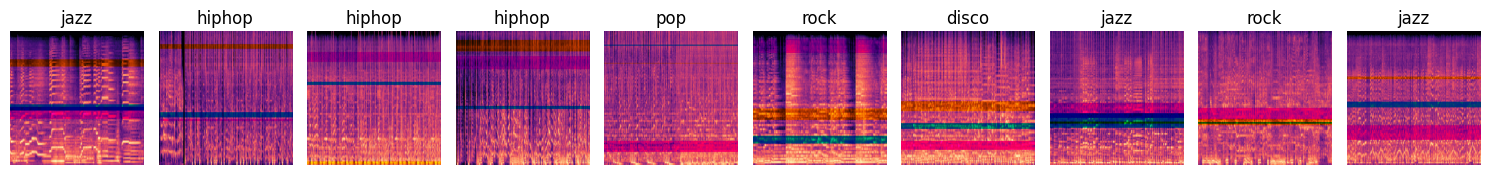

In [5]:
import matplotlib.pyplot as plt

def visualize_images(images, labels, genres):
    n = len(images)
    plt.figure(figsize=(15, 5))

    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(genres[labels[i]])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

sample_images = X_train[:10]
sample_labels = y_train[:10]

visualize_images(sample_images, sample_labels, genres)
